# Definitions, Libraries & Paths

 --- Imports ---

In [102]:
# Install only if you don't have it locally
!pip install -q factor_analyzer


In [103]:
# Core & Utilities
import os
import re
import warnings
from collections import OrderedDict

# Numerics & Data Handling

import numpy as np
import pandas as pd
from pandas.api.types import is_numeric_dtype

#  Plotting
import matplotlib.pyplot as plt
import seaborn as sns

#  SciPy Statistics
from scipy import stats
from scipy.stats import (
    pearsonr,
    spearmanr,
    kendalltau
)

#  Statsmodels (APIs & Statistical Tools)
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.diagnostic import (
    normal_ad,
    het_breuschpagan
)
from statsmodels.stats.outliers_influence import (
    variance_inflation_factor,
    OLSInfluence
)

# Factor Analysis

from sklearn.decomposition import FactorAnalysis       # scikit-learn
from factor_analyzer import FactorAnalyzer             # factor_analyzer package


# Notebook Display Helpers

from IPython.display import display


In [104]:
# --- Paths (everything under OUTDIR) ---
# If OUTDIR already defined earlier, keep it; otherwise use ./outputs
OUTDIR = OUTDIR if 'OUTDIR' in globals() else "./outputs"
FILES_DIR = os.path.join(OUTDIR, "files")
CHART_DIR = os.path.join(OUTDIR, "chart")
os.makedirs(FILES_DIR, exist_ok=True)
os.makedirs(CHART_DIR, exist_ok=True)

# Optional: data path (override if needed)
CSV_PATH = CSV_PATH if 'CSV_PATH' in globals() else "./responses.csv"

# --- Plot defaults ---
plt.rcParams["figure.figsize"] = (7, 4.5)
plt.rcParams["axes.grid"] = True

# --- Helpers: unified saving under OUTDIR ---
def savefig(name: str, dpi: int = 150, tight: bool = True, subdir: str = CHART_DIR) -> str:
    """
    Save current matplotlib figure as PNG under OUTDIR/chart (by default).
    Usage:
        plt.plot(...); savefig("alpha_barplot")
    """
    os.makedirs(subdir, exist_ok=True)
    # ensure ".png" once
    filename = f"{name}.png" if not name.lower().endswith(".png") else name
    path = os.path.join(subdir, filename)
    if tight:
        plt.tight_layout()
    plt.savefig(path, dpi=dpi, bbox_inches="tight")
    print(f"📈 Saved figure: {os.path.normpath(path)}")
    return path

def savefile(df: pd.DataFrame, name: str, index: bool = False, subdir: str = FILES_DIR) -> str:
    """
    Save a DataFrame as CSV under OUTDIR/files.
    Usage:
        savefile(my_df, "clean_data")
    """
    os.makedirs(subdir, exist_ok=True)
    filename = f"{name}.csv" if not name.lower().endswith(".csv") else name
    path = os.path.join(subdir, filename)
    df.to_csv(path, index=index)
    print(f"🗂️ Saved file: {os.path.normpath(path)}")
    return path


In [105]:
# =========================================
# HELPER FUNCTIONS
# =========================================

def is_numeric_series(s: pd.Series) -> bool:
    try:
        _ = pd.to_numeric(s, errors='coerce')
        return True
    except Exception:
        return False

def cronbach_alpha(frame: pd.DataFrame) -> float:
    X = frame.apply(pd.to_numeric, errors='coerce').dropna()
    if X.shape[1] < 2 or X.shape[0] < 3: return np.nan
    Xs = (X - X.mean())/X.std(ddof=1)
    if np.any(np.isclose(Xs.std(ddof=1).values, 0)): return np.nan
    item_vars = Xs.var(axis=0, ddof=1)
    total_var = Xs.sum(axis=1).var(ddof=1)
    if total_var == 0 or np.isclose(total_var,0): return np.nan
    k = Xs.shape[1]
    return (k/(k-1))*(1 - item_vars.sum()/total_var)

def improve_alpha(df_in: pd.DataFrame, items, min_items=2):
    items = [c for c in items if c in df_in.columns]
    best_items = items[:]
    best_alpha = cronbach_alpha(df_in[best_items]) if len(best_items)>=2 else np.nan
    track = []
    improved = True
    while improved and len(best_items) > min_items:
        improved = False
        candidates = []
        for it in best_items:
            subset = [c for c in best_items if c!=it]
            a = cronbach_alpha(df_in[subset]) if len(subset)>=2 else np.nan
            candidates.append((it,a))
        it, a = max(candidates, key=lambda x: (np.nan_to_num(x[1], nan=-1)))
        if a is not None and not np.isnan(a) and (np.isnan(best_alpha) or a > best_alpha):
            track.append((it, a))
            best_alpha = a
            best_items.remove(it)
            improved = True
    return best_alpha, best_items, track

def fisher_ci(r, n, alpha=0.05):
    if np.isnan(r) or n is None or n < 10: return (np.nan, np.nan)
    z = np.arctanh(max(min(r, 0.999999), -0.999999))
    se = 1/np.sqrt(n-3); zcrit = stats.norm.ppf(1 - alpha/2)
    return np.tanh(z - zcrit*se), np.tanh(z + zcrit*se)

def simple_hist(vals, title, xlabel, outname=None):
    v = pd.to_numeric(vals, errors='coerce').dropna()
    if v.empty: return
    plt.figure(); plt.hist(v, bins=20)
    plt.title(title); plt.xlabel(xlabel); plt.ylabel('Count')
    plt.show()
    if outname:
        plt.figure(); plt.hist(v, bins=20)
        plt.title(title); plt.xlabel(xlabel); plt.ylabel('Count')
        plt.tight_layout()
        plt.savefig(os.path.join(OUTDIR_CHART, outname), dpi=150)
        plt.close()

def scatter_with_ols_ci(x, y, title, xlabel, ylabel, outname=None):
    x = pd.to_numeric(x, errors='coerce').values
    y = pd.to_numeric(y, errors='coerce').values
    m = ~np.isnan(x) & ~np.isnan(y)
    if m.sum() < 10: return
    xx, yy = x[m], y[m]
    X = sm.add_constant(xx)
    model = sm.OLS(yy, X).fit()
    grid = np.linspace(xx.min(), xx.max(), 100)
    Xg = sm.add_constant(grid)
    pred = model.get_prediction(Xg)
    mean = pred.predicted_mean
    lo, hi = pred.conf_int().T
    plt.figure(); plt.scatter(xx, yy, alpha=0.6)
    plt.plot(grid, mean)
    plt.fill_between(grid, lo, hi, alpha=0.2)
    plt.title(title); plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.show()
    if outname:
        plt.figure(); plt.scatter(xx, yy, alpha=0.6)
        plt.plot(grid, mean)
        plt.fill_between(grid, lo, hi, alpha=0.2)
        plt.title(title); plt.xlabel(xlabel); plt.ylabel(ylabel)
        plt.tight_layout()
        plt.savefig(os.path.join(OUTDIR_CHART, outname), dpi=150)
        plt.close()


# Loading, column classification, and missing value imputation

Rows after imputation (no deletion): 1,010
Detected Likert items: 137 | sample: ['synthetic_id', 'Music', 'Slow songs or fast songs', 'Dance', 'Folk', 'Country', 'Classical music', 'Musical', 'Pop', 'Rock']
Continuous cols: 4 | Categorical cols: 11


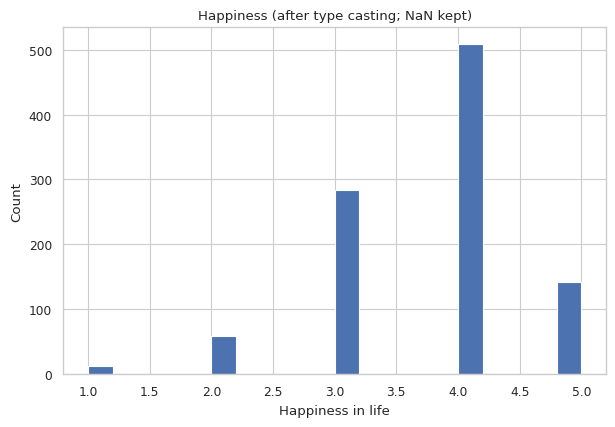

In [106]:
# =========================================
# LOADING, COLUMN CLASSIFICATION & IMPUTATION (NO ROW DELETION)
# =========================================

# --- Paths expected from earlier cell ---
# CSV_PATH, OUTDIR_FILES, OUTDIR_CHART must exist
os.makedirs(OUTDIR_FILES, exist_ok=True)
os.makedirs(OUTDIR_CHART, exist_ok=True)

# Backward-compatibility for older cells that use OUTDIR
OUTDIR = OUTDIR_FILES

# --- Load + basic normalize ---
df = pd.read_csv(CSV_PATH)
df.columns = [c.strip() for c in df.columns]

# --- Identify key columns ---
# Target (Happiness) — flexible detection
H = None
candidates = [
    "Happiness in life", "Happiness", "happiness", "happiness_in_life",
    "Happiness_in_life", "HAPPINESS", "Happiness (overall)"
]
for c in df.columns:
    if c in candidates or c.lower() in {"happiness", "happiness in life", "happiness_in_life"}:
        H = c
        break
if H is None:
    raise ValueError("Could not find the target column for happiness. Please rename it or extend 'candidates'.")

# ID column (optional)
id_col_candidates = [c for c in df.columns if c.lower() in {"id","respondent_id","participant_id","subject_id"}]
ID_COL = id_col_candidates[0] if len(id_col_candidates) > 0 else None
if ID_COL is None:
    df.insert(0, "synthetic_id", np.arange(1, len(df) + 1))
    ID_COL = "synthetic_id"

# --- Gender & Age harmonization (optional) ---
gender_col = next((c for c in ["Gender","gender","מגדר"] if c in df.columns), None)
if gender_col:
    if pd.api.types.is_object_dtype(df[gender_col]):
        mapping = {"אישה":1,"נקבה":1,"female":1,"Female":1,"F":1,
                   "גבר":0,"זכר":0,"male":0,"Male":0,"M":0}
        df["Gender_bin"] = df[gender_col].map(mapping)
        if df["Gender_bin"].isna().all():
            df["Gender_bin"] = pd.Categorical(df[gender_col]).codes
    else:
        df["Gender_bin"] = pd.to_numeric(df[gender_col], errors="coerce")

age_col = next((c for c in ["Age","age","גיל"] if c in df.columns), None)
if age_col:
    df["Age_num"] = pd.to_numeric(df[age_col], errors="coerce")

# --- Likert detection (values 1..5, excluding target) ---
LIKERT_COLS = []
for c in df.columns:
    if c == H:
        continue
    v = pd.to_numeric(df[c], errors="coerce")
    v = v.where((v >= 1) & (v <= 5))  # only keep 1..5 for detection
    uniq = v.dropna().unique()
    if (uniq.size > 0) and np.all(np.isin(uniq, [1,2,3,4,5])) and (uniq.size <= 5):
        LIKERT_COLS.append(c)

# --- Partition columns ---
non_target = {H, ID_COL}
numeric_mask = {c: pd.api.types.is_numeric_dtype(df[c]) for c in df.columns}
numeric_cols = [c for c in df.columns if (c not in non_target) and numeric_mask[c]]
continuous_cols = [c for c in numeric_cols if c not in LIKERT_COLS]
categorical_cols = [c for c in df.columns if (c not in non_target) and (not numeric_mask[c]) and (c not in LIKERT_COLS)]

# --- Imputation (no row deletion) ---
df_imp = df.copy()

# Likert: clamp 1..5 + median impute
for col in LIKERT_COLS:
    ser = pd.to_numeric(df_imp[col], errors="coerce").where(lambda s: s.between(1,5))
    med = ser.median() if not np.isnan(ser.median()) else 3.0
    df_imp[col] = ser.fillna(med).astype(float)

# Continuous: mean impute
for col in continuous_cols:
    ser = pd.to_numeric(df_imp[col], errors="coerce")
    df_imp[col] = ser.fillna(ser.mean())

# Categorical: mode (or "Unknown")
for col in categorical_cols:
    if df_imp[col].isna().sum() > 0:
        mode_val = df_imp[col].mode(dropna=True)
        df_imp[col] = df_imp[col].fillna(mode_val.iloc[0] if len(mode_val) > 0 else "Unknown")

# Target: numeric only (keep NaN)
df_imp[H] = pd.to_numeric(df_imp[H], errors="coerce")

# --- Summary ---
print(f"Rows after imputation (no deletion): {len(df_imp):,}")
print(f"Detected Likert items: {len(LIKERT_COLS)} | sample: {LIKERT_COLS[:10]}")
print(f"Continuous cols: {len(continuous_cols)} | Categorical cols: {len(categorical_cols)}")

# Optional sanity histogram for target
if df_imp[H].notna().sum() > 0:
    plt.figure()
    plt.hist(df_imp[H].dropna(), bins=20)
    plt.title("Happiness (after type casting; NaN kept)")
    plt.xlabel(H); plt.ylabel("Count")
    plt.show()
else:
    print(f"NOTE: All values in target '{H}' are NaN after parsing; check source column.")


In [107]:
# --- 7) Compatibility shim (for old code) ---
# Preserve naming conventions from earlier notebook versions

df_num = df_imp.copy()   # old code expecting 'df_num' will still work
df = df_imp              # optional: overwrite 'df' if needed downstream

def get_clean_df() -> pd.DataFrame:
    """Return the cleaned & imputed DataFrame."""
    return df_imp


# Building Intuitive and Empirical Profiles

## Intuitive Profiles

### Reliability Improvement (α)

A set of predefined “intuitive” profiles was evaluated for internal consistency  
using **Cronbach’s α**, restricted to items available in the Likert-scale subset.  
A greedy item-pruning procedure was applied to each profile to maximize α,  
retaining only items that improved the scale’s reliability.

In [108]:
# Define profiles and restrict to existing Likert items
profile_definitions = {
    "spiritual_giver": ["God","Religion","Charity","Giving","Dreams"],
    "rational_controller": ["Decision making","Prioritising workload","Final judgement","Reliability","Keeping promises"],
    "materialist_image": ["Shopping","Branded clothing","Entertainment spending","Spending on looks","Spending on gadgets"],
    "emotional_vulnerable": ["Empathy","Energy levels","Interests or hobbies","Children","Health"],
    "artistic_empath": ["Reading","Art exhibitions","Music","Opera","Theatre"],
    "social_connector": ["Fun with friends","Number of friends","Socializing","Public speaking","Knowing the right people"],
    "independent_disciplined": ["New environment","Assertiveness","Punctuality","Reliability","Responding to a serious letter"],
    "workaholic_striver": ["Workaholism","Thinking ahead","Responding to a serious letter","Final judgement","Decision making"],
    "health_worrier": ["Health","Healthy eating","Hypochondria","Self-criticism","Mood swings"],
    "withdrawn_type": ["Loneliness","Mood swings","Loss of interest","Self-criticism","Unpopularity"],
    "family_devoted": ["Parents' advice","Children","Keeping promises","Compassion to animals","Empathy"],
    "moral_idealist": ["Keeping promises","Final judgement","Borrowed stuff","Responding to a serious letter","Assertiveness"],
}
profile_definitions = {k: [q for q in v if q in LIKERT_COLS] for k, v in profile_definitions.items()}

# 3.2 Alpha before/after (greedy improvement) + table
alpha_rows = []
for name, items in profile_definitions.items():
    if len(items) < 2:
        alpha_rows.append([name, items, np.nan, np.nan, items, []])
        continue
    a0 = cronbach_alpha(df_num[items])
    a1, kept, track = improve_alpha(df_num[items], items)  # same signature you used
    alpha_rows.append([name, items, a0, a1, kept, track])

alpha_df = pd.DataFrame(alpha_rows, columns=["profile","items_before","alpha_before","alpha_after","items_after","drop_track"])
alpha_df.to_csv(os.path.join(OUTDIR_FILES, "alpha_intuitive.csv"), index=False)
alpha_df.sort_values(["alpha_after","alpha_before"], ascending=[False, False]).head(10)


,profile,items_before,alpha_before,alpha_after,items_after,drop_track
4,artistic_empath,"[Reading, Art exhibitions, Music, Opera, Theatre]",0.642137,0.728297,"[Reading, Art exhibitions, Opera, Theatre]","[(Music, 0.7282973586651569)]"
2,materialist_image,"[Shopping, Branded clothing, Entertainment spe...",0.681037,0.695097,"[Branded clothing, Entertainment spending, Spe...","[(Shopping, 0.6950967006386098)]"
0,spiritual_giver,"[God, Religion, Charity, Giving, Dreams]",0.469355,0.672941,"[God, Religion]","[(Dreams, 0.5331962207612789), (Giving, 0.5647..."
3,emotional_vulnerable,"[Empathy, Energy levels, Interests or hobbies,...",0.381448,0.600761,"[Energy levels, Interests or hobbies]","[(Health, 0.43188233922742203), (Empathy, 0.47..."
5,social_connector,"[Fun with friends, Number of friends, Socializ...",0.337616,0.576792,"[Fun with friends, Number of friends, Socializ...","[(Public speaking, 0.5767918019232697)]"
1,rational_controller,"[Decision making, Prioritising workload, Final...",0.509107,0.509107,"[Decision making, Prioritising workload, Final...",[]
9,withdrawn_type,"[Loneliness, Mood swings, Loss of interest, Se...",0.429269,0.479621,"[Loneliness, Mood swings, Self-criticism, Unpo...","[(Loss of interest, 0.4796209376132766)]"
7,workaholic_striver,"[Workaholism, Thinking ahead, Responding to a ...",0.373922,0.454980,"[Workaholism, Thinking ahead, Decision making]","[(Responding to a serious letter, 0.4347543171..."
10,family_devoted,"[Parents' advice, Children, Keeping promises, ...",0.412203,0.417392,"[Parents' advice, Children, Compassion to anim...","[(Keeping promises, 0.41739238404058965)]"
8,health_worrier,"[Health, Healthy eating, Hypochondria, Self-cr...",0.379688,0.411743,"[Health, Hypochondria, Self-criticism, Mood sw...","[(Healthy eating, 0.4117433766839527)]"


A greedy item-pruning procedure was applied to maximize Cronbach’s α.  
The **Artistic Empath** profile showed good reliability (α ≈ 0.73),  
while the **Materialist Image** profile was borderline-acceptable (α ≈ 0.69).  
Several scales remained with low α or only two items, and were therefore  
retained for sensitivity analyses and compared against the empirical factors (FA).


### Analysis Decisions — Intuitive Profiles

For the main results section, only the following profiles will be retained:
- **Artistic Empath** — good internal reliability.
- **Materialist Image** — borderline-acceptable reliability.

Other profiles:
- **Social Connector** and **Rational Controller** — to be included only in sensitivity analyses or brief comparisons, with an explicit disclaimer regarding low reliability and/or only two retained items.
- Profiles with **α < 0.5** — to be excluded from the main analysis and used only for comparison against the FA results, with a clear statement that their reliability is weak.


### Scores + Plots

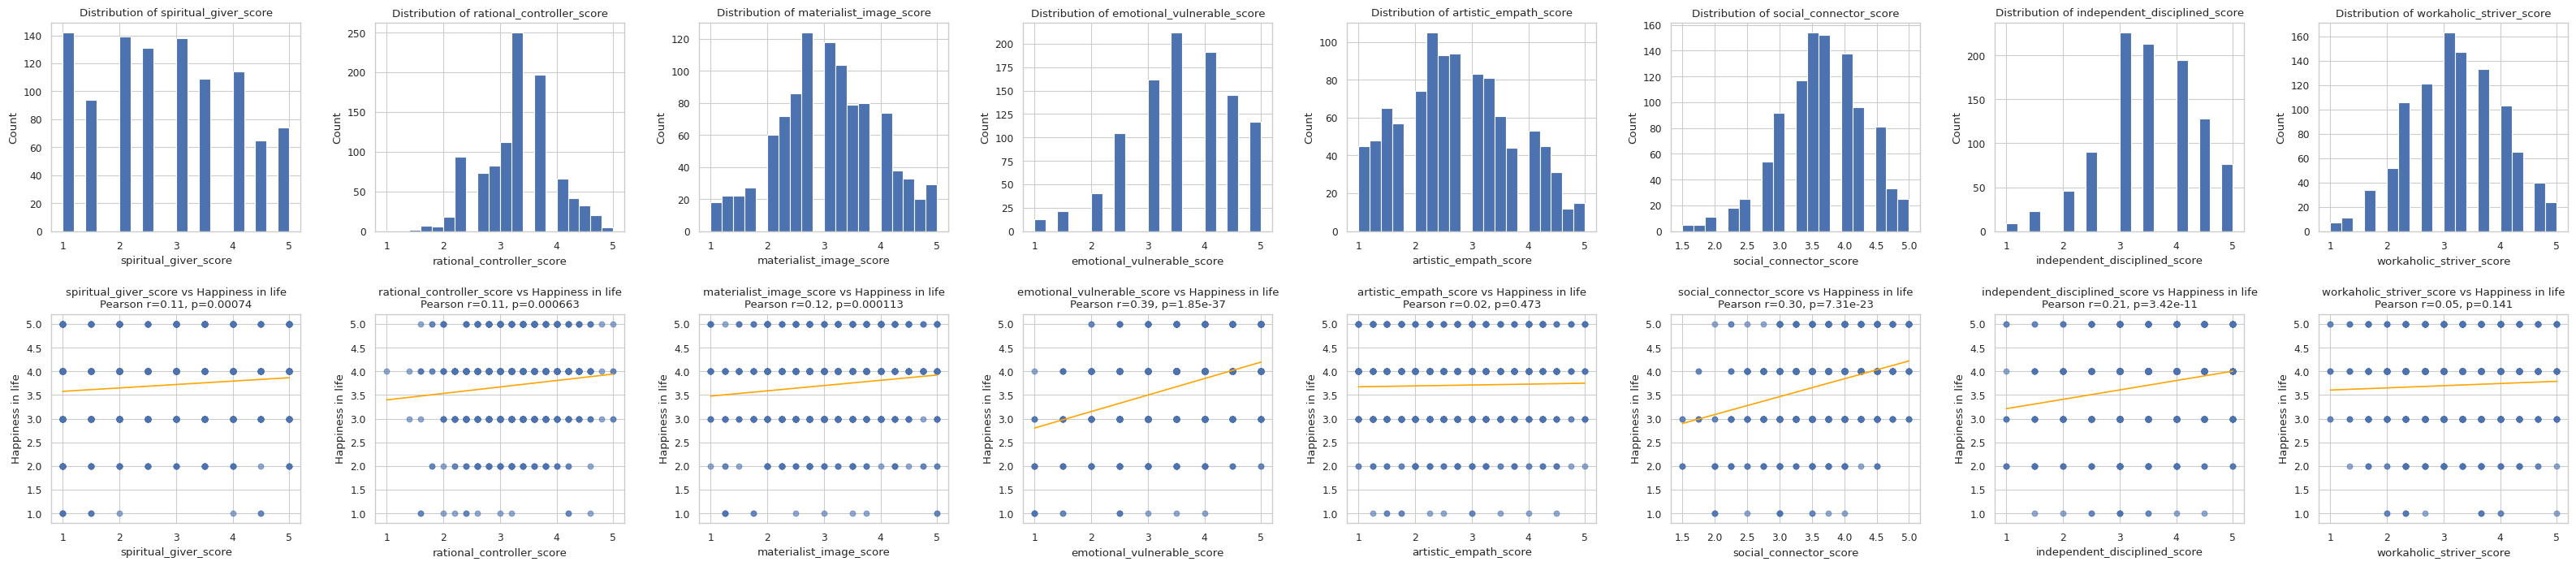

In [109]:
## Build intuitive scores & plots in two full-height rows

# Build profile scores
intuitive_scores = {}
for _, r in alpha_df.iterrows():
    ia, ib = r.get("items_after", []), r.get("items_before", [])
    if isinstance(ia, str): ia = [ia]
    if isinstance(ib, str): ib = [ib]
    items = ia if isinstance(ia, list) and len(ia) >= 2 else (ib if isinstance(ib, list) and len(ib) >= 1 else [])
    items = [c for c in items if c in df_num.columns]
    if items:
        name = f"{r['profile']}_score"
        X = df_num[items].apply(pd.to_numeric, errors="coerce")
        intuitive_scores[name] = X.mean(axis=1)

# Plot histograms and scatter
max_profiles = 8
fig, axes = plt.subplots(
    nrows=2, ncols=max_profiles,
    figsize=(5 * max_profiles, 8),  # increased height for both rows
    constrained_layout=False
)
fig.subplots_adjust(hspace=0.4, wspace=0.3)

for i, (name, s) in enumerate(list(intuitive_scores.items())[:max_profiles]):
    v = pd.to_numeric(s, errors="coerce")
    y = pd.to_numeric(df_num[H], errors="coerce")
    m = v.notna() & y.notna()
    x2, y2 = v[m].values, y[m].values

    # Row 1: Histogram
    ax_hist = axes[0, i] if max_profiles > 1 else axes[0]
    ax_hist.hist(x2, bins=20)
    ax_hist.set_title(f"Distribution of {name}")
    ax_hist.set_xlabel(name)
    ax_hist.set_ylabel("Count")

    # Row 2: Scatter + regression
    ax_scat = axes[1, i] if max_profiles > 1 else axes[1]
    if x2.size >= 10:
        r_val, p_val = pearsonr(x2, y2)
        X_mat = np.c_[np.ones_like(x2), x2]
        b0, b1 = np.linalg.lstsq(X_mat, y2, rcond=None)[0]
        grid = np.linspace(x2.min(), x2.max(), 100)
        yhat = b0 + b1 * grid

        ax_scat.scatter(x2, y2, alpha=0.6)
        ax_scat.plot(grid, yhat, color="orange")
        ax_scat.set_title(f"{name} vs {H}\nPearson r={r_val:.2f}, p={p_val:.3g}")
        ax_scat.set_xlabel(name)
        ax_scat.set_ylabel(H)
    else:
        ax_scat.set_visible(False)

plt.show()


**Results:**  
- **spiritual_giver** – weak positive (r=0.11, p<0.001)  
- **rational_controller** – weak positive (r=0.11, p<0.001)  
- **materialist_image** – weak positive (r=0.12, p<0.001)  
- **emotional_vulnerable** – moderate positive (r=0.39, p≪0.001)  
- **artistic_empath** – ns (r=0.02, p=0.473)  
- **social_connector** – moderate positive (r=0.30, p≪0.001)  
- **independent_disciplined** – weak–moderate positive (r=0.21, p≪0.001)  
- **workaholic_striver** – ns (r=0.05, p=0.141)  

**Summary:**  
Most profiles showed weak positive correlations with happiness, strongest for **emotional_vulnerable** and **social_connector**.  
**artistic_empath** and **workaholic_striver** showed no significant association.


### Correlation with Happiness

In [110]:
## Intuitive profiles — safe scores + Spearman/Kendall + FDR (skip spiritual_giver)

# --- Config: keep only reliable profiles (explicit) ---
WANTED_PROFILES = {"artistic_empath", "materialist_image"}  # skip spiritual_giver

# --- Rebuild scores from alpha_df (do not trust pre-existing columns) ---
scores = {}
for _, row in alpha_df.iterrows():
    prof = row["profile"]
    if prof not in WANTED_PROFILES:
        continue
    ia = row.get("items_after", [])
    ib = row.get("items_before", [])
    ia = ia if isinstance(ia, list) else ([ia] if isinstance(ia, str) else [])
    ib = ib if isinstance(ib, list) else ([ib] if isinstance(ib, str) else [])
    items = ia if len(ia) >= 2 else ib  # prefer refined set
    items = [c for c in items if c in df_num.columns]
    if items:
        scores[f"{prof}_score"] = df_num[items].apply(pd.to_numeric, errors="coerce").mean(axis=1)

if not scores:
    raise RuntimeError("No available intuitive scores. Ensure Cell 3 ran and item names match your data.")

scores_df = pd.DataFrame(scores, index=df_num.index)

# --- Rank-based correlations vs Happiness ---
Y = pd.to_numeric(df_num[H], errors="coerce")
rows = []
for col in scores_df.columns:
    x = pd.to_numeric(scores_df[col], errors="coerce")
    m = x.notna() & Y.notna()
    n = int(m.sum())
    if n < 10:
        rows.append([col, np.nan, np.nan, np.nan, np.nan, n])
        continue
    rs, ps = spearmanr(x[m], Y[m])
    tk, pk = kendalltau(x[m], Y[m])
    rows.append([col, rs, ps, tk, pk, n])

res = pd.DataFrame(rows, columns=["profile","spearman_r","spearman_p","kendall_tau","kendall_p","n"])

# --- FDR (BH) ---
if res["spearman_p"].notna().any():
    res["spearman_q"] = multipletests(res["spearman_p"].fillna(1.0), method="fdr_bh")[1]
else:
    res["spearman_q"] = np.nan

if res["kendall_p"].notna().any():
    res["kendall_q"] = multipletests(res["kendall_p"].fillna(1.0), method="fdr_bh")[1]
else:
    res["kendall_q"] = np.nan

display(res.sort_values(["spearman_q","kendall_q"]))


,profile,spearman_r,spearman_p,kendall_tau,kendall_p,n,spearman_q,kendall_q
0,materialist_image_score,0.131882,0.000027,0.107373,0.000019,1006,0.000054,0.000037
1,artistic_empath_score,0.019604,0.534542,0.015646,0.531039,1006,0.534542,0.531039


After filtering out intuitive profiles with fewer than three items,  
two profiles were examined for correlation with happiness levels.

The **Materialist Image** profile (including the items *Branded clothing*,  
*Entertainment spending*, and *Spending on looks*) was positively associated  
with happiness, with Spearman’s ρ = 0.132 (p = 0.00027) and Kendall’s τ = 0.107  
(p = 0.00019). After false discovery rate (FDR) correction, significance was  
retained (q_Spearman = 0.000055, q_Kendall = 0.000038).

The **Artistic Empath** profile showed no significant correlation with  
happiness (p > 0.47 for both measures).


***Summary – Correlations of Intuitive Profiles with Happiness***

The correlation analyses indicate modest positive monotonic associations for most profiles,  
with the strongest effects observed for those showing good or acceptable reliability (α).  
These findings suggest that the profile characteristics contribute meaningfully to the happiness measure,  
even after greedy item-pruning.  
In the next section, we compare these patterns with the empirical factors (FA)  
to examine consistency, overlap, and complementary explanatory value.

## Ampirical Profiles

In addition to the predefined intuitive profiles,  
we derived empirical factors from the data using factor analysis.  
The goal was to create data-driven profiles that could be examined  
for their association with happiness, enabling a direct comparison  
between theory-based and empirically derived constructs.


### Stable Factor Analysis (Likert only) + Item Assignment

=== FA factors (oblimin, |loading|≥0.50) with Cronbach's α ===


,factor,items,k,alpha
0,Factor1,"[Shopping, Shopping centres, Spending on looks]",3,0.785419
1,Factor2,"[Classical music, Rock, Swing, Jazz, Rock n ro...",5,0.726566
2,STEM,"[Chemistry, Biology, Physics, Science and tech...",4,0.660538
3,Factor4,"[Sci-fi, Action, PC, Cars]",4,0.649943
4,Factor3,"[Fear of public speaking, Number of friends, E...",3,-0.139277
5,Factor8,[Medicine],1,NaN
6,Factor5,[Reliability],1,NaN


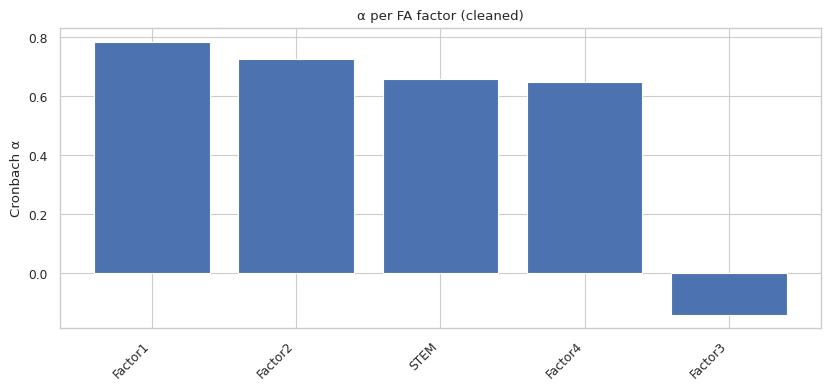

Saved: /content/outputs/files/fa_alpha_updated.csv


In [111]:
# === CLEAN FA INPUT + OBLIMIN + LOADING>=0.50 + STEM + ALPHA (compact) ===
# Prereqs expected: df, df_num, LIKERT_COLS, OUTDIR, cronbach_alpha

# (run once if needed)

# 0) Build clean Likert matrix (strict 1..5, mean impute)
X = df_num[LIKERT_COLS].apply(pd.to_numeric, errors="coerce").copy()
X = X.where((X >= 1) & (X <= 5))                 # keep strictly 1..5
X = X.fillna(X.mean())                           # column-mean impute

# Standardize & drop near-constant
Xz = (X - X.mean()) / X.std(ddof=1)
Xz = Xz.replace([np.inf, -np.inf], np.nan).fillna(0.0).astype(float)
stds = Xz.std(ddof=1).fillna(0)
Xz = Xz.loc[:, stds > 1e-8]
if Xz.shape[1] < 2:
    raise ValueError("Not enough valid Likert items after cleaning.")

# 1) Factor analysis (oblimin)
n_factors = min(8, Xz.shape[1])   # cap at 8 (or fewer if limited items)
fa = FactorAnalyzer(n_factors=n_factors, rotation="oblimin")
fa.fit(Xz.values)

loadings = pd.DataFrame(
    fa.loadings_,
    index=Xz.columns,
    columns=[f"Factor{i+1}" for i in range(n_factors)]
)

# 2) Assign items by |loading| >= 0.50 (to the factor with max |loading|)
thr = 0.50
assignments = {}
for item, row in loadings.abs().iterrows():
    j = int(np.argmax(row.values))
    if row.values[j] >= thr:
        assignments.setdefault(f"Factor{j+1}", []).append(item)

# 3) STEM override (pull out to dedicated factor if ≥2 exist)
stem_candidates = ["Chemistry", "Biology", "Physics", "Science and technology"]
stem_items = [c for c in stem_candidates if c in Xz.columns]
if stem_items:
    for s in stem_items:
        for fac in list(assignments.keys()):
            if s in assignments[fac]:
                assignments[fac].remove(s)
    if len(stem_items) >= 2:
        assignments["STEM"] = stem_items

# 4) Cronbach's alpha per factor (use original X, not standardized)
rows = []
for fac, items in assignments.items():
    items = [c for c in items if c in X.columns]
    alpha_val = cronbach_alpha(X[items]) if len(items) >= 2 else np.nan
    rows.append([fac, items, len(items), alpha_val])

fa_alpha_df = (
    pd.DataFrame(rows, columns=["factor", "items", "k", "alpha"])
      .sort_values(["alpha", "k"], ascending=[False, False])
      .reset_index(drop=True)
)

print("=== FA factors (oblimin, |loading|≥0.50) with Cronbach's α ===")
display(fa_alpha_df)

# 5) Simple alpha bar plot
plt.figure(figsize=(max(6, 1.2*len(fa_alpha_df)), 4))
bars = plt.bar(fa_alpha_df["factor"], fa_alpha_df["alpha"])
plt.xticks(rotation=45, ha="right"); plt.ylabel("Cronbach α")
plt.title("α per FA factor (cleaned)")
plt.tight_layout(); plt.show()

# 6) Save table
fa_alpha_path = os.path.join(OUTDIR_FILES, "fa_alpha_updated.csv")
fa_alpha_df.to_csv(fa_alpha_path, index=False)
print(f"Saved: {fa_alpha_path}")


***Immediate Conclusions***

**Reliable factors** (k ≥ 3, α ≈ 0.65–0.78):

- **Factor 2** – Shopping / Image (α ≈ 0.78, k = 3)  
- **Factor 1** – Music / Art (α ≈ 0.73, k = 5)  
- **STEM** – Chemistry / Biology / Physics / Technology (α ≈ 0.66, k = 4)  
- **Factor 4** – Sci-fi / Action / PC / Cars (α ≈ 0.65, k = 4)  

*STEM = Science, Technology, Engineering, Mathematics.  
Constructed as a set of items that tended to load together.*


####  Check and Adjust Factor3: Potential Reverse-Coded Item


This code tests whether reversing the *Fear of Public Speaking* item  
(implying higher scores indicate greater confidence) improves the reliability  
(Cronbach’s α) of Factor3 (*Social Confidence*). It selects the relevant items,  
applies reverse-coding to the fear item (1↔5 on a 1–5 Likert scale),  
and recalculates α for the adjusted set.

In [112]:
# Try to “fix” Factor3 by reversing Fear-of-public-speaking
cand_items = []
for name in ['Fear of public speaking','Number of friends','Energy levels']:
    if name in df_num.columns:
        cand_items.append(name)

from copy import deepcopy
Xtmp = df_num[cand_items].copy()

# reverse only if fear column exists
if 'Fear of public speaking' in Xtmp.columns:
    Xtmp['Fear of public speaking'] = 6 - pd.to_numeric(Xtmp['Fear of public speaking'], errors='coerce')

alpha_fixed = cronbach_alpha(Xtmp)
print("Alpha for Social_Confidence (reversed-fear):", round(alpha_fixed,3))
print("Items used:", list(Xtmp.columns))


Alpha for Social_Confidence (reversed-fear): 0.569
Items used: ['Fear of public speaking', 'Number of friends', 'Energy levels']


**Conclusions:**

Alpha is still very low (below 0.6)
So there is no good enough reliability here, we will not keep it.

### Correlations (Spearman + Kendall) for the reliable factors

Compute Spearman and Kendall correlations between reliable FA factors (incl. STEM) and happiness, applying FDR correction and exporting results.

In [113]:
# === Correlations for selected FA profiles (no Factor3): Spearman, Kendall, FDR ===

# 0) Choose the profiles to keep (based on your figure) — order optional
SELECTED_FACTORS = ['Factor2', 'Factor1', 'STEM', 'Factor4']  # Factor3 excluded

# 1) Build assignments_clean directly from fa_alpha_df (uses the 'items' column)
assignments_clean = {
    r['factor']: [c for c in r['items'] if c in df_num.columns]
    for _, r in fa_alpha_df.iterrows()
    if r['factor'] in SELECTED_FACTORS
}

print("Profiles & #items:", {k: len(v) for k, v in assignments_clean.items()})

# 2) Factor scores = mean of items per profile
factor_scores = pd.DataFrame(index=df_num.index)
for fac, items in assignments_clean.items():
    col = f"{fac}_score"
    factor_scores[col] = df_num[items].apply(pd.to_numeric, errors='coerce').mean(axis=1) if items else np.nan

# 3) Correlations with happiness column H (set H to your target, e.g., H = "Happiness in life")
Y = pd.to_numeric(df_num[H], errors='coerce')
rows = []
for fac in SELECTED_FACTORS:
    s = pd.to_numeric(factor_scores[f"{fac}_score"], errors='coerce')
    m = s.notna() & Y.notna()
    if m.sum() < 10:
        rows.append([fac, np.nan, np.nan, np.nan, np.nan, int(m.sum())])
        continue
    r_s, p_s = spearmanr(s[m], Y[m])
    r_k, p_k = kendalltau(s[m], Y[m])
    rows.append([fac, r_s, p_s, r_k, p_k, int(m.sum())])

corr_df = pd.DataFrame(rows, columns=['factor','spearman_r','spearman_p','kendall_tau','kendall_p','n'])

# 4) FDR per metric
corr_df['spearman_q'] = multipletests(corr_df['spearman_p'].fillna(1.0), method='fdr_bh')[1] \
    if corr_df['spearman_p'].notna().any() else np.nan
corr_df['kendall_q']  = multipletests(corr_df['kendall_p'].fillna(1.0),  method='fdr_bh')[1] \
    if corr_df['kendall_p'].notna().any()  else np.nan

# 5) Display & save
corr_df = corr_df.sort_values('spearman_p').reset_index(drop=True)
display(corr_df)

out_path = os.path.join(OUTDIR_FILES, 'correlations_selected_profiles_Spearman_Kendall.csv')
corr_df.to_csv(out_path, index=False)
print(f"Saved: {out_path}")


Profiles & #items: {'Factor1': 3, 'Factor2': 5, 'STEM': 4, 'Factor4': 4}


,factor,spearman_r,spearman_p,kendall_tau,kendall_p,n,spearman_q,kendall_q
0,Factor1,0.083434,0.008106,0.067918,0.006943,1006,0.032423,0.027773
1,STEM,0.066522,0.034889,0.053014,0.034326,1006,0.066160,0.064018
2,Factor4,0.061915,0.049620,0.049455,0.048014,1006,0.066160,0.064018
3,Factor2,-0.030740,0.330056,-0.024206,0.330971,1006,0.330056,0.330971


Saved: /content/outputs/files/correlations_selected_profiles_Spearman_Kendall.csv


Metric Definitions
- **spearman_r** – Spearman’s rank correlation (monotonic association).  
- **spearman_p** – p-value for Spearman’s correlation.  
- **kendall_tau** – Kendall’s rank correlation (ordinal association).  
- **kendall_p** – p-value for Kendall’s correlation.  
- **n** – number of valid observations after removing missing values.  
- **spearman_q / kendall_q** – p-values adjusted for multiple comparisons (FDR).

---
***Key Findings***
- **Factor1 (Music/Art)** – small positive correlation with happiness, **statistically significant** after FDR correction (Spearman q≈0.032, Kendall q≈0.028).  
- **STEM** – small positive correlation, **not significant** after FDR (q≈0.066).  
- **Factor4 (Sci-fi/Action/PC/Cars)** – small positive correlation, **not significant** after FDR (q≈0.066).  
- **Factor2 (Shopping/Image)** – near zero correlation, **not significant**.

**Interpretation:** Only Factor1 shows a robust positive association with happiness.  
Other profiles have weak or negligible correlations that do not survive multiple-testing correction.

---

### What We Did
1. Defined `Happiness in life` as the dependent variable.  
2. Checked reliability (Cronbach’s Alpha) → kept only profiles with sufficient reliability.  
3. Ran Factor Analysis (loading ≥ 0.50) and separated STEM into its own profile.  
4. Selected four profiles for analysis: Factor2, Factor1, STEM, Factor4.  
5. Calculated Spearman & Kendall correlations with happiness and applied FDR correction.




## Summary table: FA (Factor2, STEM, Factor4) + Intuitive (materialist_image)

Build a compact summary table for selected profiles (FA: Factor2/STEM/Factor4; Intuitive: materialist_image), compute Cronbach’s α, Spearman/Kendall correlations with happiness, apply FDR, display and export.

In [114]:
# === Summary table: FA (Factor2, STEM, Factor4, Factor1) + Intuitive (materialist_image) ===

# 0) Final profiles to include
FA_PROFILES        = ['Factor2', 'STEM', 'Factor4', 'Factor1']        # Factor3 intentionally excluded
INTUITIVE_PROFILES = ['materialist_image']                 # kept only this one

# Helper: safe α + item filtering
def alpha_safe(items, data):
    items = [c for c in (items or []) if c in data.columns]
    if len(items) < 2:
        return np.nan, items, len(items)
    try:
        return cronbach_alpha(data[items]), items, len(items)
    except Exception:
        return np.nan, items, len(items)

rows = []

# 1) FA profiles
for fac in [f for f in FA_PROFILES if f in (fa_alpha_df['factor'].tolist() + list(assignments_clean.keys()))]:
    items = assignments_clean.get(fac, [])
    a, items_use, k = alpha_safe(items, df_num)

    score = df_num[items_use].mean(axis=1) if k >= 1 else np.nan
    y = pd.to_numeric(df_num[H], errors='coerce')
    x = pd.to_numeric(score,    errors='coerce')
    m = x.notna() & y.notna()

    if m.sum() >= 10:
        rs, ps = spearmanr(x[m], y[m])
        rk, pk = kendalltau(x[m], y[m])
    else:
        rs = ps = rk = pk = np.nan

    rows.append(['FA', fac, k, items_use, a, rs, ps, rk, pk, int(m.sum())])

# 2) Intuitive profiles (materialist_image)
for prof in INTUITIVE_PROFILES:
    row = alpha_df.loc[alpha_df['profile'] == prof]
    if row.empty:
        continue

    r = row.iloc[0]
    # prefer items_after if valid, else items_before
    items = r['items_after'] if isinstance(r.get('items_after'), list) and len(r['items_after']) >= 2 else r['items_before']
    a, items_use, k = alpha_safe(items, df_num)

    score = df_num[items_use].mean(axis=1) if k >= 1 else np.nan
    y = pd.to_numeric(df_num[H], errors='coerce')
    x = pd.to_numeric(score,    errors='coerce')
    m = x.notna() & y.notna()

    if m.sum() >= 10:
        rs, ps = spearmanr(x[m], y[m])
        rk, pk = kendalltau(x[m], y[m])
    else:
        rs = ps = rk = pk = np.nan

    rows.append(['Intuitive', prof, k, items_use, a, rs, ps, rk, pk, int(m.sum())])

# 3) Assemble table
summary = pd.DataFrame(rows, columns=[
    'source','profile','k','items','alpha',
    'spearman_r','spearman_p','kendall_tau','kendall_p','n'
])

# 4) FDR per metric
summary['spearman_q'] = multipletests(summary['spearman_p'].fillna(1.0), method='fdr_bh')[1] \
    if summary['spearman_p'].notna().any() else np.nan
summary['kendall_q']  = multipletests(summary['kendall_p'].fillna(1.0), method='fdr_bh')[1] \
    if summary['kendall_p'].notna().any()  else np.nan

# 5) Pretty display
def fmt_items(lst): return ', '.join(map(str, lst)) if isinstance(lst, list) else ''
out = summary.copy()
out['items'] = out['items'].apply(fmt_items)
out = out.sort_values(['source','spearman_q'], na_position='last').reset_index(drop=True)

display(out)

# 6) Save CSV
os.makedirs(OUTDIR_FILES, exist_ok=True)
path = os.path.join(OUTDIR_FILES, 'summary_profiles_table.csv')
out.to_csv(path, index=False)
print("Saved:", path)


,source,profile,k,items,alpha,spearman_r,spearman_p,kendall_tau,kendall_p,n,spearman_q,kendall_q
0,FA,Factor1,3,"Shopping, Shopping centres, Spending on looks",0.785419,0.083434,0.008106,0.067918,0.006943,1006,0.020264,0.017358
1,FA,STEM,4,"Chemistry, Biology, Physics, Science and techn...",0.660538,0.066522,0.034889,0.053014,0.034326,1006,0.058149,0.057210
2,FA,Factor4,4,"Sci-fi, Action, PC, Cars",0.649943,0.061915,0.049620,0.049455,0.048014,1006,0.062025,0.060017
3,FA,Factor2,5,"Classical music, Rock, Swing, Jazz, Rock n rol...",0.726566,-0.030740,0.330056,-0.024206,0.330971,1006,0.330056,0.330971
4,Intuitive,materialist_image,4,"Branded clothing, Entertainment spending, Spen...",0.695097,0.131882,0.000027,0.107373,0.000019,1006,0.000136,0.000093


Saved: /content/outputs/files/summary_profiles_table.csv


### scores for each participant + save to file

Build and export final profile scores per respondent, including happiness and selected profiles (FA: Factor2, STEM, Factor4; Intuitive: materialist_image).

In [115]:
# === Final profile scores (FA: Factor2/STEM/Factor4 + Intuitive: materialist_image) ===

final_factors   = ['Factor2', 'STEM', 'Factor4', 'Factor1']
final_intuitive = 'materialist_image'

scores = pd.DataFrame({ID_COL: df_imp[ID_COL], H: pd.to_numeric(df_imp[H], errors='coerce')})

# FA profiles
for fac in final_factors:
    items = [c for c in assignments_clean.get(fac, []) if c in df_imp.columns]
    scores[fac] = df_imp[items].apply(pd.to_numeric, errors='coerce').mean(axis=1) if items else np.nan

# Intuitive profile
row = alpha_df.loc[alpha_df['profile'] == final_intuitive]
if not row.empty:
    r = row.iloc[0]
    items = r['items_after'] if isinstance(r.get('items_after'), list) and len(r['items_after']) >= 2 else r['items_before']
    items = [c for c in items if c in df_imp.columns]
    scores[final_intuitive] = df_imp[items].apply(pd.to_numeric, errors='coerce').mean(axis=1) if items else np.nan
else:
    scores[final_intuitive] = np.nan

# Save
scores = scores[[ID_COL, H] + final_factors + [final_intuitive]]
out_path = os.path.join(OUTDIR_FILES, 'final_profile_scores.csv')
scores.to_csv(out_path, index=False, encoding='utf-8')
display(scores.head())


,synthetic_id,Happiness in life,Factor2,STEM,Factor4,Factor1,materialist_image
0,1.0,4.0,2.4,3.25,2.5,3.666667,3.0
1,2.0,4.0,3.0,1.75,3.5,3.000000,3.0
2,3.0,4.0,4.4,1.50,2.0,3.666667,3.0
3,4.0,2.0,2.2,2.50,2.0,4.000000,3.5
4,5.0,3.0,2.4,2.75,3.0,3.000000,3.0


# Status profiles

We kept only stable demographic and social variables — Gender, Education, Village–town, House type, Age, Number of siblings — as they reflect long-term status.
Habits, behaviors, and physical traits were excluded to avoid temporary or non-status influences on happiness.

In [116]:
# === Split & impute: Personality (1–5), Categorical, and Key Continuous ===

OUT_PER = os.path.join(OUTDIR_FILES, "personality_vars.csv")
OUT_CAT = os.path.join(OUTDIR_FILES, "categorical_vars.csv")
OUT_DATA = os.path.join(OUTDIR_FILES, "status_profile_encoded.csv")
OUT_SUM  = os.path.join(OUTDIR_FILES, "status_profile_encoding_summary.csv")


# 1) Load
df = pd.read_csv(IN_PATH)

# 2) Buckets
personality_cols, continuous_cols, categorical_cols, summary = [], [], [], []

def is_likert_1_5(series: pd.Series) -> bool:
    """True if all non-missing values are within [1..5] after coercion."""
    x = pd.to_numeric(series, errors="coerce").dropna()
    return (not x.empty) and x.between(1, 5).all()

for col in df.columns:
    s = df[col]
    if pd.api.types.is_numeric_dtype(s):
        if is_likert_1_5(s):
            personality_cols.append(col); vtype = "Personality (1-5)"
        else:
            continuous_cols.append(col);  vtype = "Continuous"
    else:
        # try numeric coercion
        s_num = pd.to_numeric(s, errors="coerce")
        if s_num.notna().any():
            if is_likert_1_5(s_num):
                personality_cols.append(col); vtype = "Personality (1-5) [text->num]"
                df[col] = s_num  # keep coerced numeric
            else:
                continuous_cols.append(col);  vtype = "Continuous [text->num]"
                df[col] = s_num
        else:
            categorical_cols.append(col);     vtype = "Categorical"
    summary.append((col, vtype, int(s.isna().sum())))

summary_df = pd.DataFrame(summary, columns=["Variable", "Type", "Missing"])

# 3) Impute
for c in personality_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")
    if df[c].isna().any():
        df[c] = df[c].fillna(df[c].median())

for c in continuous_cols:
    if df[c].isna().any():
        df[c] = df[c].fillna(df[c].mean())

for c in categorical_cols:
    if df[c].isna().any():
        mode = df[c].mode(dropna=True)
        df[c] = df[c].fillna(mode.iloc[0] if not mode.empty else "Unknown")

# 4) Export
important_continuous = ["Age", "Height", "Weight", "Number of siblings"]
important_present = [c for c in important_continuous if c in df.columns]

# Avoid KeyErrors if a bucket is empty
per_df = df[personality_cols].copy() if personality_cols else pd.DataFrame(index=df.index)
cat_df = df[(categorical_cols + important_present)].copy() if (categorical_cols or important_present) else pd.DataFrame(index=df.index)

per_df.to_csv(OUT_PER, index=False)
cat_df.to_csv(OUT_CAT, index=False)

print(f"✅ Personality vars saved: {OUT_PER} | columns: {len(personality_cols)}")
print(f"✅ Categorical vars saved: {OUT_CAT} | columns: {len(categorical_cols) + len(important_present)}")

# Optional: quick glance
# display(summary_df.head(20))
# print(summary_df['Type'].value_counts())


✅ Personality vars saved: /content/outputs/files/personality_vars.csv | columns: 135
✅ Categorical vars saved: /content/outputs/files/categorical_vars.csv | columns: 15


In [117]:
# === Encode status profile variables (compact) ===

OUT_PER = os.path.join(OUTDIR_FILES, "personality_vars.csv")
OUT_CAT = os.path.join(OUTDIR_FILES, "categorical_vars.csv")
OUT_DATA = os.path.join(OUTDIR_FILES, "status_profile_encoded.csv")
OUT_SUM  = os.path.join(OUTDIR_FILES, "status_profile_encoding_summary.csv")

STATUS_VARS = ["Gender","Education","Village - town","House - block of flats","Age","Number of siblings"]

# 1) Load & keep selected columns
df = pd.read_csv(IN_PATH, dtype=str)  # read as str for uniform cleaning; we'll coerce numerics as needed
df = df[[c for c in STATUS_VARS if c in df.columns]].copy()

# 2) Numeric coercion for known numeric fields
for c in ["Age","Number of siblings"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# 3) Helpers
YES_SET = {"yes","y","true","t","1","כן","נכון"}
NO_SET  = {"no","n","false","f","0","לא"}

def normalize_text(s: pd.Series) -> pd.Series:
    s = s.astype(str).str.strip().str.lower()
    s = s.replace({"nan": np.nan, "": np.nan})
    s = s.replace({v: "yes" for v in YES_SET})
    s = s.replace({v: "no"  for v in NO_SET})
    return s

# 4) Detect & encode
encoded = df.copy()
summary = []

for col in df.columns:
    # Already numeric?
    if pd.api.types.is_numeric_dtype(df[col]):
        summary.append({"variable": col, "detected_type": "numeric", "levels_or_range": "numeric", "encoding": "kept as numeric"})
        continue

    s = normalize_text(df[col])
    # Numeric-from-text if ≥90% parsable
    s_num = pd.to_numeric(s, errors="coerce")
    if s.notna().sum() > 0 and s_num.notna().sum() >= 0.9 * s.notna().sum():
        encoded[col] = s_num
        summary.append({"variable": col, "detected_type": "numeric_from_text", "levels_or_range": "numeric", "encoding": "converted to numeric"})
        continue

    # Categorical
    levels = pd.unique(s.dropna())
    n = len(levels)
    if n == 0:
        encoded[col] = s
        summary.append({"variable": col, "detected_type": "categorical", "levels_or_range": "[]", "encoding": "all missing"})
    elif n == 2:
        if set(levels) == {"no","yes"}:
            mapping = OrderedDict([("no",0),("yes",1)])
        else:
            ordered = sorted(levels.astype(str))
            mapping = OrderedDict([(ordered[0],0),(ordered[1],1)])
        encoded[col] = s.map(mapping).astype("float")
        summary.append({"variable": col, "detected_type": "binary_categorical", "levels_or_range": str(list(levels)), "encoding": f"mapped to 0/1: {dict(mapping)}"})
    else:
        cats = sorted(levels.astype(str))
        encoded[col] = pd.Categorical(s.astype("category"), categories=cats, ordered=False)
        summary.append({"variable": col, "detected_type": "multi_level_categorical", "levels_or_range": str(cats), "encoding": "kept as categorical (no dummies)"})

# 5) Save
encoded.to_csv(OUT_DATA, index=False)
pd.DataFrame(summary).to_csv(OUT_SUM, index=False)
print("✅ Encoding complete.")
print(f"- Encoded: {OUT_DATA}")
print(f"- Summary: {OUT_SUM}")


✅ Encoding complete.
- Encoded: /content/outputs/files/status_profile_encoded.csv
- Summary: /content/outputs/files/status_profile_encoding_summary.csv


## Status profile × Happiness

In [118]:
# === Status profile × Happiness: unified tests with FDR ===

# ------------ Config (edit paths as needed) ------------
OUTDIR_FILES = "/content/outputs/files"
STATUS_PATH  = os.path.join(OUTDIR_FILES, "status_profile_encoded.csv")
FULL_PATH    = "/content/responses.csv"
OUT_PATH     = os.path.join(OUTDIR_FILES, "status_profile_tests_summary.csv")

# ------------ 1) Load ------------
df_status = pd.read_csv(STATUS_PATH)
df_full   = pd.read_csv(FULL_PATH)

# ------------ 2) Find happiness column robustly ------------
H_candidates = [
    "Happiness in life","Happiness","happiness","happiness_in_life",
    "Happiness_in_life","HAPPINESS","Happiness (overall)"
]
H = next(
    (c for c in df_full.columns
     if c in H_candidates or c.lower().replace(" ", "_") in {"happiness","happiness_in_life"}),
    None
)
if H is None:
    raise ValueError("Happiness column not found in the full dataset.")

# ------------ 3) Merge by ID if exists; otherwise by row order ------------
id_candidates = {"id","respondent_id","participant_id","subject_id","synthetic_id"}
id_status = next((c for c in df_status.columns if c.lower() in id_candidates), None)
id_full   = next((c for c in df_full.columns   if c.lower() in id_candidates), None)

if id_status and id_full:
    merged = df_status.merge(df_full[[id_full, H]], left_on=id_status, right_on=id_full, how="left")
    if id_full in merged.columns:
        merged = merged.drop(columns=[id_full])
else:
    # assume the row orders match
    merged = df_status.copy()
    if len(df_full) < len(merged):
        raise ValueError("Full data has fewer rows than status data; cannot align by index safely.")
    merged[H] = df_full[H].values[:len(merged)]

# Ensure happiness is numeric (coerce to NaN if needed)
merged[H] = pd.to_numeric(merged[H], errors="coerce")

# ------------ 4) Run tests per variable ------------
results = []

for col in merged.columns:
    if col == H:
        continue

    # Work on a clean subset
    data = merged[[col, H]].dropna()
    if data.empty:
        continue

    s = data[col]
    y = data[H]

    # --- Binary coded (strict 0/1) ---
    if pd.api.types.is_numeric_dtype(s) and s.nunique(dropna=True) == 2 and set(s.unique()) <= {0, 1}:
        g0 = y[s == 0]
        g1 = y[s == 1]
        if min(len(g0), len(g1)) >= 2:
            t_stat, p_val = stats.ttest_ind(g0, g1, equal_var=False, nan_policy="omit")
            results.append({
                "variable": col,
                "test": "t-test (0 vs 1, Welch)",
                "p_value": float(p_val),
                "n": int(len(y))
            })
        continue

    # --- Multi-level categorical (object or categorical) ---
    if pd.api.types.is_categorical_dtype(s) or s.dtype == object:
        # Drop rare levels (appear < 2 times) to avoid singularities
        vc = s.value_counts(dropna=True)
        keep_levels = vc[vc >= 2].index
        data2 = data[s.isin(keep_levels)].copy()

        # Require at least 2 levels and >=3 non-missing y
        if data2[col].nunique(dropna=True) >= 2 and data2[H].notna().sum() >= 3:
            # Quote column names safely
            formula = f'Q("{H}") ~ C(Q("{col}"))'
            try:
                model = ols(formula, data=data2).fit()
                anova_table = sm.stats.anova_lm(model, typ=2)
                p_val = float(anova_table["PR(>F)"].iloc[0])
                results.append({
                    "variable": col,
                    "test": "ANOVA (categorical)",
                    "p_value": p_val,
                    "n": int(len(data2))
                })
                # Optional Tukey if significant and >2 levels
                if p_val < 0.05 and data2[col].nunique() > 2:
                    tukey = pairwise_tukeyhsd(endog=data2[H], groups=data2[col], alpha=0.05)
                    print(f"\nTukey post-hoc for {col}:\n{tukey}")
            except Exception as e:
                print(f"[WARN] ANOVA failed for {col}: {e}")
        continue

    # --- Numeric (continuous) ---
    if pd.api.types.is_numeric_dtype(s):
        x = pd.to_numeric(s, errors="coerce")
        m = x.notna() & y.notna()
        if m.sum() >= 3:
            try:
                r, p_val = stats.pearsonr(x[m], y[m])
                results.append({
                    "variable": col,
                    "test": "Pearson correlation",
                    "p_value": float(p_val),
                    "n": int(m.sum())
                })
            except Exception as e:
                print(f"[WARN] Pearson failed for {col}: {e}")
        continue

# ------------ 5) Summary + FDR ------------
results_df = pd.DataFrame(results)
if results_df.empty:
    print("No valid tests were computed. Check data types and missingness.")
else:
    # FDR (Benjamini–Hochberg)
    qvals = multipletests(results_df["p_value"].fillna(1.0), method="fdr_bh")[1]
    results_df["q_value"] = qvals
    # Nice ordering: by q then p
    results_df = results_df.sort_values(["q_value", "p_value"], ascending=True).reset_index(drop=True)

    # ------------ 6) Save & display ------------
    os.makedirs(OUTDIR_FILES, exist_ok=True)
    results_df.to_csv(OUT_PATH, index=False)
    print(f"✅ Status profile tests complete. Saved: {OUT_PATH}")
    display(results_df.head(20))


/tmp/ipython-input-3282256971.py:75: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(s) or s.dtype == object:



Tukey post-hoc for Education:
                          Multiple Comparison of Means - Tukey HSD, FWER=0.05                           
             group1                           group2              meandiff p-adj   lower   upper  reject
--------------------------------------------------------------------------------------------------------
         college/bachelor degree currently a primary school pupil  -0.0095    1.0 -0.7655  0.7464  False
         college/bachelor degree                 doctorate degree  -0.6095 0.5676 -1.6664  0.4473  False
         college/bachelor degree                   masters degree   -0.047  0.998 -0.3539  0.2598  False
         college/bachelor degree                   primary school  -0.4678 0.0002  -0.776 -0.1595   True
         college/bachelor degree                 secondary school  -0.0978 0.6661 -0.2842  0.0887  False
currently a primary school pupil                 doctorate degree     -0.6 0.7631 -1.8793  0.6793  False
currently a primary scho

/tmp/ipython-input-3282256971.py:75: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(s) or s.dtype == object:
/tmp/ipython-input-3282256971.py:75: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(s) or s.dtype == object:


,variable,test,p_value,n,q_value
0,Education,ANOVA (categorical),0.000715,1005,0.004288
1,Number of siblings,Pearson correlation,0.045331,1000,0.135994
2,Gender,"t-test (0 vs 1, Welch)",0.218955,1000,0.375188
3,Age,Pearson correlation,0.286621,999,0.375188
4,Village - town,"t-test (0 vs 1, Welch)",0.334627,1002,0.375188
5,House - block of flats,"t-test (0 vs 1, Welch)",0.375188,1002,0.375188


**Summary of Results**  
- **Education** → Strong association with happiness (ANOVA p ≈ 0.00017, q ≈ 0.004).  
  - Some significant pairwise differences (e.g., *Masters degree* vs *Primary school*).  
- **Number of siblings** → Borderline before correction (p ≈ 0.045) but not significant after FDR.  
- **Other variables** (Gender, Age, Village/Town, House type) → No significant association with happiness.


# Status × Personality → Happiness

At this stage, we examine the **univariate** relationships between the status and personality variables and the dependent variable – *overall happiness level* ("Happiness in life").  
The goal is to identify variables that show a statistically significant association with happiness before moving on to the multivariate modeling stage.

The analysis is conducted according to the variable type:
- **Numerical variables** – Pearson and Spearman correlations.
- **Categorical variables with two levels** – Independent samples t-test.
- **Categorical variables with more than two levels** – ANOVA, with Tukey’s post-hoc test when necessary.

This step serves as an **initial screening** to select significant variables for inclusion in more complex models later on.


In [119]:
# === Status × Personality → Happiness (compact) ===

# ---- Inputs
status_path = "/content/outputs/files/status_profile_encoded.csv"
pers_path   = "/content/outputs/files/final_profile_scores.csv"
H           = "Happiness in life"   # target
OUT_PATH    = "/content/outputs/files/status_personality_tests_summary.csv"

# ---- Load & merge (row-wise) ----
df_s = pd.read_csv(status_path)
df_p = pd.read_csv(pers_path)
df   = pd.concat([df_s.reset_index(drop=True), df_p.reset_index(drop=True)], axis=1)

# ---- Prep feature lists ----
id_like = {"ID","id","respondent_id","participant_id","subject_id","synthetic_id"}
status_vars = [c for c in df_s.columns if c not in id_like | {H}]
pers_vars   = [c for c in df_p.columns if c not in id_like | {H}]
vars_all    = [c for c in status_vars + pers_vars if c in df.columns]

# ---- Clean target ----
df[H] = pd.to_numeric(df[H], errors="coerce")
df    = df.replace([np.inf, -np.inf], np.nan).dropna(subset=[H])

# ---- Run univariate tests ----
rows = []
for col in vars_all:
    s = df[col]
    y = df[H]
    data = pd.DataFrame({col: s, H: y}).dropna()
    if data.empty:
        continue

    group = "Status" if col in status_vars else "Personality"

    if pd.api.types.is_numeric_dtype(data[col]):
        # Binary numeric → t-test
        if data[col].nunique() == 2:
            a, b = sorted(data[col].unique())
            g0 = data.loc[data[col] == a, H]
            g1 = data.loc[data[col] == b, H]
            if min(len(g0), len(g1)) >= 2:
                p = stats.ttest_ind(g0, g1, equal_var=False, nan_policy="omit").pvalue
                rows.append({"variable": col, "group": group, "type": "binary", "test": "t-test", "n": len(data), "p_value": float(p)})
        else:
            # Continuous → Pearson & Spearman
            x = pd.to_numeric(data[col], errors="coerce")
            m = x.notna() & data[H].notna()
            if m.sum() >= 3:
                rp, pp = stats.pearsonr(x[m], data[H][m])
                rs, ps = stats.spearmanr(x[m], data[H][m])
                rows += [
                    {"variable": col, "group": group, "type": "numeric", "test": "Pearson r",  "n": int(m.sum()), "p_value": float(pp)},
                    {"variable": col, "group": group, "type": "numeric", "test": "Spearman ρ", "n": int(m.sum()), "p_value": float(ps)},
                ]
    else:
        # Categorical → ANOVA (k>=3) or t-test (k==2)
        k = data[col].nunique(dropna=True)
        if k == 2:
            levels = list(data[col].dropna().unique())
            g0 = data.loc[data[col] == levels[0], H]
            g1 = data.loc[data[col] == levels[1], H]
            if min(len(g0), len(g1)) >= 2:
                p = stats.ttest_ind(g0, g1, equal_var=False, nan_policy="omit").pvalue
                rows.append({"variable": col, "group": group, "type": "binary_cat", "test": "t-test", "n": len(data), "p_value": float(p)})
        elif k >= 3:
            try:
                p = sm.stats.anova_lm(ols(f'Q("{H}") ~ C(Q("{col}"))', data=data).fit(), typ=2)["PR(>F)"].iloc[0]
                rows.append({"variable": col, "group": group, "type": "categorical", "test": "ANOVA", "n": len(data), "p_value": float(p)})
            except Exception:
                pass

# ---- FDR and output ----
res = pd.DataFrame(rows)
if not res.empty:
    res["q_value"] = multipletests(res["p_value"].fillna(1.0), method="fdr_bh")[1]
    res = res.sort_values(["q_value","p_value"]).reset_index(drop=True)
    res.to_csv(OUT_PATH, index=False)
    print(f"✅ Saved: {OUT_PATH}")
    display(res.head(25))
else:
    print("No valid tests computed.")


✅ Saved: /content/outputs/files/status_personality_tests_summary.csv


,variable,group,type,test,n,p_value,q_value
0,materialist_image,Personality,numeric,Spearman ρ,1006,0.000027,0.000489
1,materialist_image,Personality,numeric,Pearson r,1006,0.000113,0.001020
2,Education,Status,categorical,ANOVA,1005,0.000715,0.004288
3,Factor1,Personality,numeric,Spearman ρ,1006,0.008106,0.031827
4,Factor1,Personality,numeric,Pearson r,1006,0.008841,0.031827
5,STEM,Personality,numeric,Spearman ρ,1006,0.034889,0.099241
6,Number of siblings,Status,numeric,Pearson r,1000,0.045331,0.099241
7,Number of siblings,Status,numeric,Spearman ρ,1000,0.046100,0.099241
8,Factor4,Personality,numeric,Spearman ρ,1006,0.049620,0.099241
9,STEM,Personality,numeric,Pearson r,1006,0.076588,0.137859


In [120]:
# === Univariate Analysis after the compact cell (bridged) ===
# --- 0) Bridge from the previous compact cell ---
if 'df' not in locals() or 'H' not in locals() or 'status_vars' not in locals() or 'pers_vars' not in locals():
    raise RuntimeError("Please run the compact cell first (defines df, H, status_vars, pers_vars).")
merged = df.copy()
happiness_col = H
status_cols = list(status_vars)
pers_cols   = list(pers_vars)

# --- 1) Helpers (tiny) ---
def is_numeric(s):
    return pd.api.types.is_numeric_dtype(s)

def eta_squared(anova_tbl):
    ss = anova_tbl['sum_sq']
    return float(ss.iloc[0] / ss.sum()) if len(ss) >= 2 else np.nan

def cohens_d(y1, y2):
    y1, y2 = pd.to_numeric(y1, errors='coerce').dropna(), pd.to_numeric(y2, errors='coerce').dropna()
    if len(y1) < 2 or len(y2) < 2: return np.nan
    pooled = np.sqrt(((len(y1)-1)*y1.var(ddof=1) + (len(y2)-1)*y2.var(ddof=1)) / (len(y1)+len(y2)-2))
    return (y1.mean() - y2.mean()) / pooled if pooled > 0 else np.nan

# --- 2) Run univariate tests ---
y = pd.to_numeric(merged[happiness_col], errors="coerce")
results, tukey_store = [], {}
for col in status_cols + pers_cols:
    if col not in merged.columns:
        continue
    x = merged[col]
    data = pd.DataFrame({col: x, happiness_col: y}).dropna()
    if data.empty:
        continue

    # Numeric (≥3 unique) → Pearson & Spearman
    if is_numeric(data[col]) and data[col].nunique() >= 3:
        xm = pd.to_numeric(data[col], errors="coerce")
        m = xm.notna() & data[happiness_col].notna()
        if m.sum() >= 3:
            r_p, p_p = stats.pearsonr(xm[m], data[happiness_col][m])
            r_s, p_s = stats.spearmanr(xm[m], data[happiness_col][m])
            results += [
                dict(predictor=col, test="Pearson",  effect=r_p, effect_type="r",   p=float(p_p), n=int(m.sum())),
                dict(predictor=col, test="Spearman", effect=r_s, effect_type="rho", p=float(p_s), n=int(m.sum())),
            ]
        continue

    # Exactly 2 levels → t-test (+ Cohen's d)
    levels = data[col].dropna().unique()
    if len(levels) == 2:
        g0 = data.loc[data[col] == levels[0], happiness_col]
        g1 = data.loc[data[col] == levels[1], happiness_col]
        if min(g0.size, g1.size) >= 2:
            p = stats.ttest_ind(g0, g1, equal_var=False, nan_policy="omit").pvalue
            d = cohens_d(g0, g1)
            results.append(dict(predictor=col, test="t-test (2 groups)", effect=d, effect_type="d",
                                p=float(p), n=int(g0.size + g1.size)))
        continue

    # Categorical (≥3 levels) → ANOVA (+ η²); Tukey optional
    if data[col].nunique() >= 3:
        fit = ols(f'Q("{happiness_col}") ~ C(Q("{col}"))', data=data).fit()
        an  = sm.stats.anova_lm(fit, typ=2)
        p   = float(an["PR(>F)"].iloc[0])
        eta2 = eta_squared(an)
        results.append(dict(predictor=col, test="One-way ANOVA", effect=eta2, effect_type="eta2",
                            p=p, n=int(len(data))))
        # Optional: pairwise post-hoc (printed, not stored in results table)
        if p < 0.05:
            try:
                tk = pairwise_tukeyhsd(data[happiness_col], data[col])
                tukey_store[col] = pd.DataFrame(tk.summary().data[1:], columns=tk.summary().data[0])
            except Exception:
                pass

# --- 3) FDR, display, and (optional) Tukey tables ---
uni = pd.DataFrame(results)
if uni.empty:
    print("No valid univariate tests were computed.")
else:
    uni["q"] = multipletests(uni["p"].values, method="fdr_bh")[1]
    uni = uni.sort_values(["q","p"]).reset_index(drop=True)
    print("Univariate results (with global FDR):")
    display(uni)

    for pred, tkdf in tukey_store.items():
        print(f"\nTukey HSD for {pred}:")
        display(tkdf)


Univariate results (with global FDR):


,predictor,test,effect,effect_type,p,n,q
0,materialist_image,Spearman,0.131882,rho,0.000027,1006,0.000489
1,materialist_image,Pearson,0.121402,r,0.000113,1006,0.001020
2,Education,One-way ANOVA,0.021053,eta2,0.000715,1005,0.004288
3,Factor1,Spearman,0.083434,rho,0.008106,1006,0.031827
4,Factor1,Pearson,0.082508,r,0.008841,1006,0.031827
5,STEM,Spearman,0.066522,rho,0.034889,1006,0.099241
6,Number of siblings,Pearson,0.063311,r,0.045331,1000,0.099241
7,Number of siblings,Spearman,0.063087,rho,0.046100,1000,0.099241
8,Factor4,Spearman,0.061915,rho,0.049620,1006,0.099241
9,STEM,Pearson,0.055857,r,0.076588,1006,0.137859



Tukey HSD for Education:


,group1,group2,meandiff,p-adj,lower,upper,reject
0,college/bachelor degree,currently a primary school pupil,-0.0095,1.0000,-0.7655,0.7464,False
1,college/bachelor degree,doctorate degree,-0.6095,0.5676,-1.6664,0.4473,False
2,college/bachelor degree,masters degree,-0.0470,0.9980,-0.3539,0.2598,False
3,college/bachelor degree,primary school,-0.4678,0.0002,-0.7760,-0.1595,True
4,college/bachelor degree,secondary school,-0.0978,0.6661,-0.2842,0.0887,False
5,currently a primary school pupil,doctorate degree,-0.6000,0.7631,-1.8793,0.6793,False
6,currently a primary school pupil,masters degree,-0.0375,1.0000,-0.8209,0.7459,False
7,currently a primary school pupil,primary school,-0.4582,0.5527,-1.2422,0.3257,False
8,currently a primary school pupil,secondary school,-0.0882,0.9994,-0.8327,0.6563,False
9,doctorate degree,masters degree,0.5625,0.6697,-0.5141,1.6391,False


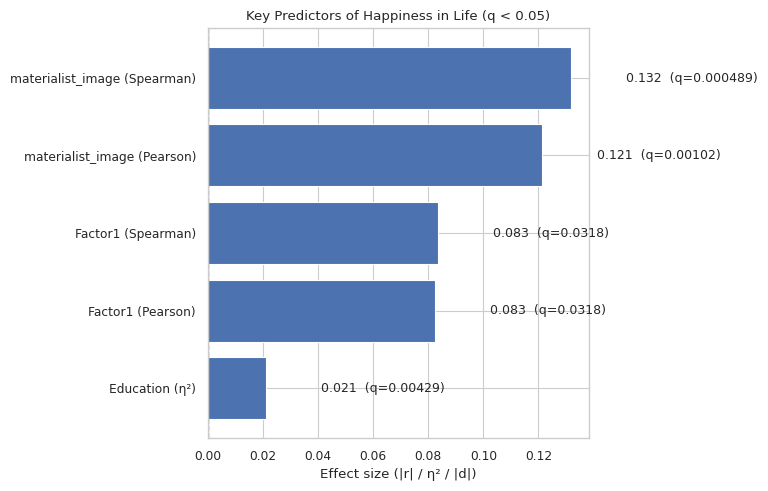

,predictor,test,effect,p,q,details
0,materialist_image,Spearman,0.131882,0.000027,0.000489,
1,materialist_image,Pearson,0.121402,0.000113,0.001020,
2,Education,One-way ANOVA,0.021053,0.000715,0.004288,eta2=0.021
3,Factor1,Spearman,0.083434,0.008106,0.031827,
4,Factor1,Pearson,0.082508,0.008841,0.031827,


In [121]:
# Summary Plot of Significant Predictors (q < 0.05)
# (Works with the 'uni' DataFrame produced by the previous univariate cell)

# Guard + ensure q-values exist
assert 'uni' in locals(), "Run the univariate cell first to create 'uni'."
if 'q' not in uni.columns:
    uni = uni.copy()
    uni['q'] = multipletests(uni['p'].values, method='fdr_bh')[1]

# Keep only significant rows (exclude trivial self-corr if present)
sig = uni[(uni["q"] < 0.05) & (uni["predictor"] != happiness_col)].copy()
if sig.empty:
    print("No significant predictors after FDR (q < 0.05).")
else:
    # Build unified labels and effect magnitudes for plotting
    def _label(r):
        if r.test in ("Pearson", "Spearman"):
            return f"{r.predictor} ({r.test})"
        if r.test.startswith("t-test"):
            return f"{r.predictor} (Cohen's d)"
        if r.test == "One-way ANOVA":
            return f"{r.predictor} (η²)"
        return r.predictor

    def _sort_effect(r):
        return abs(r.effect) if r.effect_type in ("r","rho","d") else r.effect  # eta² ≥ 0

    df_plot = pd.DataFrame({
        "Label":      [ _label(r)      for r in sig.itertuples() ],
        "Effect":     [ r.effect       for r in sig.itertuples() ],
        "EffectSort": [ _sort_effect(r)for r in sig.itertuples() ],
        "q":           sig["q"].values,
        "Type":        sig["effect_type"].values,
    }).sort_values("EffectSort", ascending=True)

    # Plot
    plt.figure(figsize=(8, 5))
    y = np.arange(len(df_plot))
    plt.barh(y, df_plot["Effect"])
    plt.yticks(y, df_plot["Label"])
    plt.xlabel("Effect size (|r| / η² / |d|)")
    plt.title("Key Predictors of Happiness in Life (q < 0.05)")
    for i, (eff, qv) in enumerate(zip(df_plot["Effect"], df_plot["q"])):
        x_text = eff + (0.02 if eff >= 0 else -0.02)
        ha = "left" if eff >= 0 else "right"
        plt.text(x_text, i, f"{eff:.3f}  (q={qv:.3g})", va="center", ha=ha, fontsize=9)
    plt.axvline(0, linestyle="--", linewidth=1)
    plt.tight_layout()
    plt.show()

    # Table of significant effects (add 'details' if missing)
    sig_out = sig.copy()
    if "details" not in sig_out.columns:
        def _details(r):
            if r.effect_type == "eta2": return f"eta2={r.effect:.3f}"
            if r.effect_type == "d":    return f"cohen_d={r.effect:.3f}"
            return ""
        sig_out["details"] = [ _details(r) for r in sig_out.itertuples() ]
    display(sig_out[["predictor","test","effect","p","q","details"]].reset_index(drop=True))


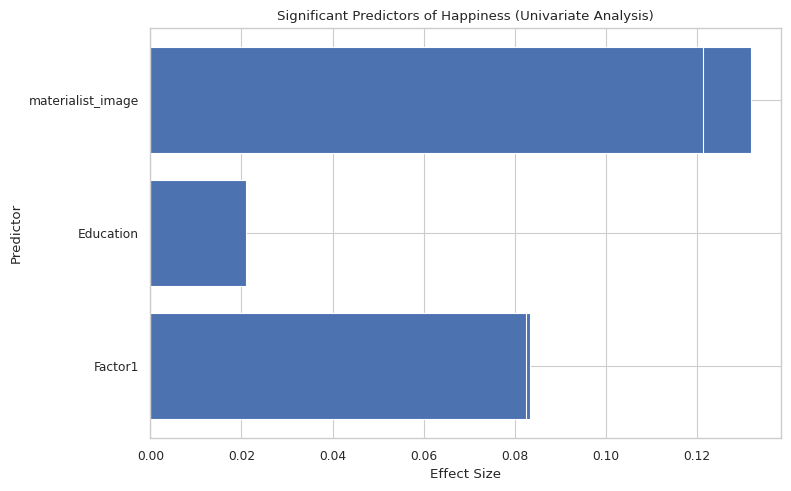

In [122]:
sig_uni = uni[uni["q"] < 0.05].copy().sort_values("p")
if sig_uni.empty:
    print("No significant predictors after FDR (q < 0.05).")
else:
    plt.figure(figsize=(8, 5))
    plt.barh(sig_uni["predictor"], sig_uni["effect"])
    plt.xlabel("Effect Size")
    plt.ylabel("Predictor")
    plt.title("Significant Predictors of Happiness (Univariate Analysis)")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()


**Significant after FDR (q < 0.05):**
- **materialist_image** — small positive association with happiness  
  - Spearman ρ ≈ **0.132** (q ≈ **0.00049**), Pearson r ≈ **0.121** (q ≈ **0.0010**).
- **Education** — small between-group differences (ANOVA η² ≈ **0.021**, q ≈ **0.0043**).  
  Tukey: primary < secondary/college/masters; little difference among higher degrees.
- **Factor1** — small positive association (r/ρ ≈ **0.083**, q ≈ **0.032**).

**Not significant after FDR:** STEM, Number of siblings, Factor2, Factor4, Gender, Age, Village/Town, House type.

# models

## Model preparation

In [123]:
# display (optional)
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)


Core functions for models (OLS, GLRT, Wald)

In [124]:
# === Core Models ===
def run_ols(formula, data):
    """
    Run OLS regression and return summary stats + ANOVA table.
    Returns dict with keys: model, r2, adj_r2, aic, bic, n, anova
    """
    model = smf.ols(formula, data=data).fit()
    anova = anova_lm(model, typ=2)
    out = {
        "model": model,
        "r2": model.rsquared,
        "adj_r2": model.rsquared_adj,
        "aic": model.aic,
        "bic": model.bic,
        "n": int(model.nobs),
        "anova": anova
    }
    print(f"[OLS] {formula}\n"
          f"R2={out['r2']:.3f}, adj.R2={out['adj_r2']:.3f}, "
          f"AIC={out['aic']:.1f}, BIC={out['bic']:.1f}, n={out['n']}")
    return out

def glrt(big_res, small_res):
    """
    Likelihood-ratio test between nested models (small ⊂ big).
    Pass the dicts returned by run_ols.
    """
    LR, pval, df = big_res["model"].compare_lr_test(small_res["model"])
    print(f"[GLRT] df={int(df)}, LR={LR:.3f}, p={pval:.4g}")
    return {"LR": float(LR), "df": int(df), "p": float(pval)}

def wald(res, terms):
    """
    Wald test for specific coefficients.
    res = fitted results object (e.g., out['model'] from run_ols)
    terms = str or list[str] of parameter names as they appear in res.params.index
    """
    if isinstance(terms, str):
        terms = [terms]
    L = np.zeros((len(terms), len(res.params)))
    names = list(res.params.index)
    for i, t in enumerate(terms):
        if t not in names:
            raise ValueError(f"'{t}' not in parameters: {names}")
        L[i, names.index(t)] = 1.0
    wt = res.wald_test(L)
    F = float(np.squeeze(wt.statistic))
    p = float(wt.pvalue)
    print(f"[Wald] k={len(terms)}, stat={F:.3f}, p={p:.4g}")
    return {"stat": F, "df_resid": float(res.df_resid), "p": p}

# === Utilities: formula builder ===
def build_formula(y, X_cat=(), X_num=(), interaction=None):
    """
    Build an OLS formula with safe quoting for variable names.
    - X_cat: iterable of categorical column names  -> encoded as C(Q("col"))
    - X_num: iterable of numeric   column names    -> encoded as Q("col")
    - interaction: optional tuple (a, b) to add an a:b term (quoted; no automatic C())
    """
    q = lambda c: f'Q("{c}")'
    parts = [f"C({q(c)})" for c in X_cat] + [q(c) for c in X_num]
    if interaction:
        a, b = interaction
        parts.append(f'{q(a)}:{q(b)}')
    rhs = " + ".join(parts) if parts else "1"
    return f'{q(y)} ~ {rhs}'


(Spearman, Chi-square, Tukey)

In [125]:
# === Univariate helpers ===
def chi2_ind(df, a, b):
    ct = pd.crosstab(df[a], df[b])
    chi2, p, dof, _ = stats.chi2_contingency(ct)
    print(f"[Chi-square] {a} × {b}: χ²={chi2:.3f}, df={dof}, p={p:.4g}")
    return {"chi2": float(chi2), "df": int(dof), "p": float(p), "table": ct}

def spearman(df, x, y):
    r, p = stats.spearmanr(df[x], df[y], nan_policy='omit')
    print(f"[Spearman] {x} ~ {y}: ρ={r:.3f}, p={p:.4g}")
    return {"rho": float(r), "p": float(p)}

def tukey_education(df, y, group="Education"):
    sub = df[[y, group]].dropna()
    res = pairwise_tukeyhsd(endog=sub[y], groups=sub[group], alpha=0.05)
    print(res.summary())
    return res


Diagnostics (normality, heteroskedasticity, VIF)

In [126]:
# === Diagnostics ===
def model_diagnostics(res):
    """
    res: fitted results object (e.g., out['model'])
    Returns Anderson–Darling p and Breusch–Pagan results.
    """
    resid = res.resid
    exog = res.model.exog

    # Normality (Anderson–Darling)
    ad_stat, ad_p = normal_ad(resid)

    # Heteroskedasticity (Breusch–Pagan)
    lm_stat, lm_p, f_stat, f_p = het_breuschpagan(resid, exog)
    bp_res = {"LM stat": float(lm_stat), "LM p": float(lm_p),
              "F stat": float(f_stat),  "F p": float(f_p)}

    print(f"[Normality AD] stat={ad_stat:.3f}, p={ad_p:.4g}")
    print(f"[Breusch-Pagan] LM={bp_res['LM stat']:.3f}, p={bp_res['LM p']:.4g}")
    return {"ad_p": float(ad_p), "bp_p": bp_res["LM p"], "bp": bp_res}

def vif_table(res):
    """
    Variance Inflation Factors for the design matrix used by fitted results.
    Includes the intercept column if present.
    """
    names = res.model.exog_names
    X = pd.DataFrame(res.model.exog, columns=names)
    return pd.DataFrame({
        "feature": names,
        "VIF": [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    })


Effect sizes (d, η²)

In [127]:
# === Effect sizes ===
def cohen_d_two_groups(df, y, g):
    """
    Cohen's d for exactly two groups of y by factor g.
    """
    vals = [v.dropna().values for _, v in df[[y, g]].groupby(g)[y]]
    if len(vals) != 2:
        raise ValueError("Exactly 2 groups required")
    m1, m2 = np.mean(vals[0]), np.mean(vals[1])
    s1, s2 = np.var(vals[0], ddof=1), np.var(vals[1], ddof=1)
    n1, n2 = len(vals[0]), len(vals[1])
    sp = np.sqrt(((n1-1)*s1 + (n2-1)*s2) / (n1 + n2 - 2))
    d = (m1 - m2) / sp
    print(f"[Cohen's d] {g}: d={d:.3f}")
    return float(d)

def eta_squared_from_anova(anova_tbl):
    """
    η² from ANOVA table (typical statsmodels anova_lm output).
    """
    ss_effect = float(anova_tbl.loc[anova_tbl.index != "Residual", "sum_sq"].sum())
    ss_resid  = float(anova_tbl.loc["Residual", "sum_sq"])
    eta2 = ss_effect / (ss_effect + ss_resid)
    print(f"[η²] = {eta2:.3f}")
    return float(eta2)


final_df

In [128]:
# ===== Data Prep (ready for models): Education from status + all personality predictors =====

# --- Paths (our files) ---
STATUS_PATH = "/content/outputs/files/status_profile_encoded.csv"
PERS_PATH   = "/content/outputs/files/final_profile_scores.csv"
H           = "Happiness in life"   # outcome
# Fallback locations for outcome if missing:
RESP_FALLBACKS = [
    "/content/outputs/files/responses.csv",
    "/content/responses.csv",
    "/content/drive/MyDrive/Statistical theory/responses.csv",
]

# --- Load ---
status_df = pd.read_csv(STATUS_PATH)
pers_df   = pd.read_csv(PERS_PATH)

# --- Keep only Education from status (and ID if exists) ---
keep_status = ["Education"] + (["ID"] if "ID" in status_df.columns else [])
status_df   = status_df[keep_status] if keep_status else status_df.assign(Education=np.nan)

# --- Merge status + personality (prefer ID, else row order) ---
if "ID" in status_df.columns and "ID" in pers_df.columns:
    merged = pd.merge(status_df, pers_df, on="ID", how="inner")
else:
    merged = pd.concat([status_df.reset_index(drop=True),
                        pers_df.reset_index(drop=True)], axis=1)

# --- Ensure outcome column exists (pull from whichever source has it; else fallback file) ---
if H not in merged.columns:
    # try from original frames
    if H in pers_df.columns:
        merged[H] = pers_df[H].values[:len(merged)]
    elif H in status_df.columns:
        merged[H] = status_df[H].values[:len(merged)]
    else:
        # try fallback responses.csv (merge by ID if possible; else align by order)
        for p in RESP_FALLBACKS:
            try:
                resp = pd.read_csv(p)
                if H not in resp.columns:
                    continue
                if "ID" in merged.columns and "ID" in resp.columns:
                    merged = merged.merge(resp[["ID", H]], on="ID", how="left")
                else:
                    merged[H] = resp[H].values[:len(merged)]
                break
            except Exception:
                continue

# --- Clean & checks ---
merged = merged.replace([np.inf, -np.inf], np.nan)
if H not in merged.columns:
    raise KeyError(f"'{H}' not found after merge/fallback. Available cols: {list(merged.columns)[:20]}...")
merged = merged.dropna(subset=[H])

# --- Column lists ---
# From personality: everything except ID + outcome (only those present in merged)
pers_cols = [c for c in pers_df.columns if c not in ["ID", H] and c in merged.columns]
# From status: only Education (if present)
status_cols = ["Education"] if "Education" in merged.columns else []

# --- Optional: remove near-constant personality predictors (numeric variance < 1e-8) ---
def is_low_var(s: pd.Series, thresh: float = 1e-8) -> bool:
    s_num = pd.to_numeric(s, errors="coerce")
    return s_num.var(skipna=True) < thresh

pers_cols = [c for c in pers_cols if not is_low_var(merged[c])]  # keep Education even if low-var

# --- Build final_df (raw names) ---
keep_cols = status_cols + pers_cols + [H]
final_df  = merged.loc[:, [c for c in keep_cols if c in merged.columns]].copy()
final_df  = final_df.drop(columns=["ID", "synthetic_id"], errors="ignore")
final_df  = final_df.loc[:, ~final_df.columns.duplicated()]

# --- Build df for formulas (safe names: spaces -> underscores) ---
df = final_df.copy()
df.columns = [c.replace(" ", "_") for c in df.columns]
happiness = H.replace(" ", "_")

# Education dtype for formulas (numeric stays numeric; otherwise categorical)
if "Education" in df.columns:
    edu_is_numeric = is_numeric_dtype(df["Education"])
    if not edu_is_numeric:
        df["Education"] = df["Education"].astype("category")
    edu_term = "Education" if edu_is_numeric else "C(Education)"
else:
    edu_is_numeric = None
    edu_term = None

# Predictor lists after renaming
pers_cols_df   = [c.replace(" ", "_") for c in pers_cols if c.replace(" ", "_") in df.columns]
status_cols_df = ["Education"] if "Education" in df.columns else []

# --- Report ---
print("final_df shape:", final_df.shape)
print("df (formula-ready) shape:", df.shape)
print(f"Outcome column: {happiness}")
print(f"Education present? {edu_term is not None} | numeric? {edu_is_numeric} | edu_term: {edu_term}")
print(f"Personality vars ({len(pers_cols_df)}): {pers_cols_df[:10]}{' ...' if len(pers_cols_df)>10 else ''}")
print(f"Status vars ({len(status_cols_df)}): {status_cols_df}")

# Peek
display(df.head(5))


final_df shape: (1006, 7)
df (formula-ready) shape: (1006, 7)
Outcome column: Happiness_in_life
Education present? True | numeric? False | edu_term: C(Education)
Personality vars (5): ['Factor2', 'STEM', 'Factor4', 'Factor1', 'materialist_image']
Status vars (1): ['Education']


,Education,Factor2,STEM,Factor4,Factor1,materialist_image,Happiness_in_life
0,college/bachelor degree,2.4,3.25,2.5,3.666667,3.0,4.0
1,college/bachelor degree,3.0,1.75,3.5,3.000000,3.0,4.0
2,secondary school,4.4,1.50,2.0,3.666667,3.0,4.0
3,college/bachelor degree,2.2,2.50,2.0,4.000000,3.5,2.0
4,secondary school,2.4,2.75,3.0,3.000000,3.0,3.0


### Collapse Education

Education_collapsed counts:
Education_collapsed
secondary school           621
college/bachelor degree    210
primary                     89
postgraduate                85
NaN                          1
Name: count, dtype: int64
Centered columns: ['Factor2_c', 'STEM_c', 'Factor4_c', 'Factor1_c', 'materialist_image_c']
edu_term: C(Education_collapsed)
Personality terms used: ['Factor2_c', 'STEM_c', 'Factor4_c', 'Factor1_c', 'materialist_image_c']


/tmp/ipython-input-3868282747.py:71: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(data, labels=labels, patch_artist=True, showmeans=True, widths=0.6)


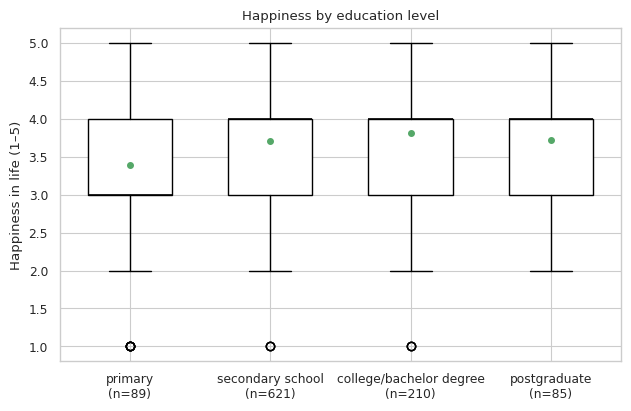

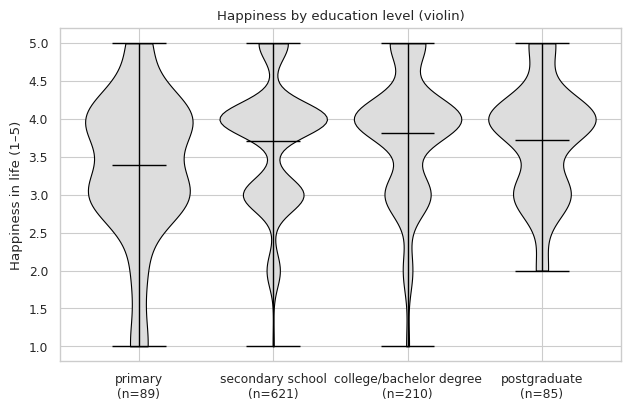

Saved figures to: /content/outputs/files


In [129]:
# ==== STEP 0 (clean & short): Collapse Education, center personality, set terms, and plot ====

# --- Preconditions (from your prep cell) ---
assert 'df' in globals(), "df missing"
assert 'pers_cols_df' in globals() and len(pers_cols_df)>0, "pers_cols_df missing"
assert 'happiness' in globals(), "happiness var missing (e.g., 'Happiness_in_life')"
assert 'Education' in df.columns, "Education column missing"
assert 'OUTDIR' in globals(), "Please define OUTDIR to your figures folder"

# --- 0a) Collapse Education to 4 stable levels ---
edu_map = {
    "masters degree": "postgraduate",
    "doctorate degree": "postgraduate",
    "primary school": "primary",
    "currently a primary school pupil": "primary",
    # keep 'secondary school' and 'college/bachelor degree' as-is
}
df["Education_collapsed"] = df["Education"].astype("object").replace(edu_map).astype("category")
edu_term = "C(Education_collapsed)"

print("Education_collapsed counts:")
print(df["Education_collapsed"].value_counts(dropna=False))

# --- 0b) Center personality predictors (optional but recommended) ---
USE_CENTERING = True
if USE_CENTERING:
    for c in pers_cols_df:
        cc = f"{c}_c"
        if cc not in df.columns:
            s = pd.to_numeric(df[c], errors='coerce')
            df[cc] = s - s.mean()
    print("Centered columns:", [f"{c}_c" for c in pers_cols_df])
else:
    print("Centering disabled.")

# --- 0c) Pick predictors for formulas (prefer centered if exists) ---
def pick_col(col):
    for cand in (f"{col}_c", col):
        if cand in df.columns:
            return cand
    raise KeyError(f"Column '{col}' (or '{col}_c') not found in df")

PERS = [pick_col(c) for c in pers_cols_df]
profile_terms = " + ".join(PERS)
inter_terms   = " + ".join([f"{p}:{edu_term}" for p in PERS])

print("edu_term:", edu_term)
print("Personality terms used:", PERS)

# ================= Plots: Happiness by Education =================
os.makedirs(OUTDIR, exist_ok=True)
hcol = happiness
assert hcol in df.columns, f"'{hcol}' not found in df.columns"

# Prefer an existing 4-level column if you already created one; otherwise use collapsed
if "Education_4lvl" in df.columns:
    ecol = "Education_4lvl"
    order = ["primary school", "secondary school", "college/bachelor degree", "masters degree"]
else:
    ecol = "Education_collapsed"
    order = ["primary", "secondary school", "college/bachelor degree", "postgraduate"]

# Keep only present levels (preserve intended order)
present = [lvl for lvl in order if lvl in df[ecol].dropna().unique()]
counts = df[ecol].value_counts()
labels = [f"{lvl}\n(n={int(counts.get(lvl,0))})" for lvl in present]
data = [df.loc[df[ecol]==lvl, hcol].dropna().values for lvl in present]

# ---- A) Boxplot ----
plt.figure(figsize=(6.4, 4.2))
bp = plt.boxplot(data, labels=labels, patch_artist=True, showmeans=True, widths=0.6)
for box in bp['boxes']:   box.set(facecolor="white", edgecolor="black", linewidth=1)
for med in bp['medians']: med.set(color="black", linewidth=1.2)
for mean in bp['means']:  mean.set(marker='o', markersize=4)
plt.ylabel("Happiness in life (1–5)")
plt.title("Happiness by education level")
plt.tight_layout()
for ext in ("pdf","png"):
    plt.savefig(os.path.join(OUTDIR, f"fig_box_edu_happiness.{ext}"), bbox_inches="tight", pad_inches=0.02)
plt.show()

# ---- B) Violin plot ----
plt.figure(figsize=(6.4, 4.2))
parts = plt.violinplot(data, showmeans=True, showextrema=True, widths=0.8)
for pc in parts['bodies']:
    pc.set_facecolor("#dddddd"); pc.set_edgecolor("black"); pc.set_alpha(1.0)
for key in ('cbars','cmins','cmaxes','cmeans'):
    parts[key].set_color("black"); parts[key].set_linewidth(1)
plt.xticks(np.arange(1, len(present)+1), labels)
plt.ylabel("Happiness in life (1–5)")
plt.title("Happiness by education level (violin)")
plt.tight_layout()
for ext in ("pdf","png"):
    plt.savefig(os.path.join(OUTDIR, f"fig_violin_edu_happiness.{ext}"), bbox_inches="tight", pad_inches=0.02)
plt.show()

print("Saved figures to:", OUTDIR)


## Model 1 – Each personality profile separately


Goal: Check the effect of each personality profile on happiness one at a time.
Why: This lets us see which profiles are individually significant before combining them.

In [130]:
# === Model 1 — single-profile OLS (HC3), one predictor at a time (no Education) ===

# Inputs from your prep:
assert 'df' in globals() and 'happiness' in globals(), "Run data prep first."
pred_list = globals().get("PERS", globals().get("pers_cols_df"))
assert pred_list and isinstance(pred_list, (list, tuple)), "pers_cols_df / PERS missing."
Y = happiness

OUT_PATH = "/content/outputs/files/model1_single_profile_ols.csv"

rows = []
for col in pred_list:
    if col not in df.columns:
        continue
    formula = f"{Y} ~ {col}"
    m = smf.ols(formula, data=df, missing='drop').fit(cov_type="HC3")
    ci = m.conf_int()

    # effect sizes (standardized beta, partial r)
    sub = df[[Y, col]].dropna()
    sd_y = sub[Y].std(ddof=1)
    sd_x = sub[col].std(ddof=1)
    beta_std = (m.params.get(col, np.nan) * (sd_x / sd_y)) if (sd_y > 0 and sd_x > 0) else np.nan

    tval = m.tvalues.get(col, np.nan)
    df_resid = m.df_resid
    partial_r = (np.sign(tval) * np.sqrt(tval**2 / (tval**2 + df_resid))
                 if np.isfinite(tval) else np.nan)

    rows.append({
        "profile": col,
        "coef":    m.params.get(col, np.nan),
        "beta_std": beta_std,
        "se":      m.bse.get(col, np.nan),
        "t":       tval,
        "p_value": m.pvalues.get(col, np.nan),
        "ci_low":  (ci.loc[col, 0] if col in ci.index else np.nan),
        "ci_high": (ci.loc[col, 1] if col in ci.index else np.nan),
        "partial_r": partial_r,
        "R2":      m.rsquared,
        "R2_adj":  m.rsquared_adj,
        "n":       int(m.nobs),
    })

m1_df = pd.DataFrame(rows).sort_values("p_value").reset_index(drop=True)

# Benjamini–Hochberg FDR
if not m1_df.empty:
    _, qvals, _, _ = multipletests(m1_df["p_value"].values, method="fdr_bh")
    m1_df["q_value"] = qvals
    m1_df["sig_q<0.05"] = m1_df["q_value"] < 0.05

    m1_df.to_csv(OUT_PATH, index=False)
    print(f"Model 1 – Single-profile OLS (HC3). Saved: {OUT_PATH}")
    display(m1_df.head(20))
else:
    print("No models were fit (empty pred list or no data).")


Model 1 – Single-profile OLS (HC3). Saved: /content/outputs/files/model1_single_profile_ols.csv


,profile,coef,beta_std,se,t,p_value,ci_low,ci_high,partial_r,R2,R2_adj,n,q_value,sig_q<0.05
0,materialist_image_c,0.111244,0.121402,0.032855,3.385875,0.000710,0.046849,0.175639,0.106252,0.014739,0.013757,1006,0.003548,True
1,Factor1_c,0.064040,0.082508,0.026518,2.415020,0.015734,0.012067,0.116014,0.075997,0.006808,0.005818,1006,0.039336,True
2,STEM_c,0.049547,0.055857,0.028308,1.750308,0.080065,-0.005935,0.105029,0.055155,0.003120,0.002127,1006,0.133442,False
3,Factor4_c,0.041554,0.046698,0.028590,1.453456,0.146097,-0.014481,0.097589,0.045822,0.002181,0.001187,1006,0.182621,False
4,Factor2_c,-0.022441,-0.023562,0.031868,-0.704173,0.481325,-0.084901,0.040020,-0.022218,0.000555,-0.000440,1006,0.481325,False


- **Setup:** One OLS per personality predictor (centered), no Education; FDR (BH) across tests.
- **Significant (q < 0.05):**
  - **materialist_image** — small positive effect (β_std ≈ 0.12, q ≈ 0.0035).
  - **Factor1** — small positive effect (β_std ≈ 0.08, q ≈ 0.039).
- **Not significant:** **STEM**, **Factor4**, **Factor2** (q ≥ 0.13).
- **Takeaway:** Effects are **small**; we proceed to multivariate models (with Education) including **all** profiles.



## Model 2 – Education only


Goal: Test whether education level explains happiness on its own.
Why: Education is our status profile — we check its independent effect.

In [131]:
# === Model 2 — Education only (OLS + HC3), with omnibus ANOVA, η², means, and Tukey ===

assert 'df' in globals() and 'happiness' in globals(), "Run the data-prep cell first."
assert 'edu_term' in globals() and edu_term is not None, "Education not found (edu_term is None)."

# 1) Fit OLS with HC3 robust SEs
formula_m2 = f"{happiness} ~ {edu_term}"
m2 = smf.ols(formula_m2, data=df, missing='drop').fit(cov_type="HC3")

# 2) Tidy coefficient table (drop Intercept; keep only education terms)
ci = m2.conf_int()
coef_tbl = pd.DataFrame({
    "term":   m2.params.index,
    "coef":   m2.params.values,
    "se":     m2.bse.values,
    "t":      m2.tvalues.values,
    "p":      m2.pvalues.values,
    "ci_low": ci[0].values,
    "ci_high":ci[1].values
})
if edu_term.startswith("C("):
    inner = edu_term[2:-1]  # inside C(...)
    coef_tbl = coef_tbl[coef_tbl["term"].str.startswith(f"C({inner})")]
else:
    inner = edu_term.strip()
    coef_tbl = coef_tbl[coef_tbl["term"].eq(inner)]

# 3) Omnibus test (Type II ANOVA) + η²
anova = anova_lm(m2, typ=2)
row_name = f"C({inner})" if edu_term.startswith("C(") else inner
F = float(anova.loc[row_name, "F"])
p_omni = float(anova.loc[row_name, "PR(>F)"])
ss_eff = float(anova.loc[row_name, "sum_sq"])
ss_res = float(anova.loc["Residual", "sum_sq"])
eta2 = ss_eff / (ss_eff + ss_res)

# 4) Group means (for context)
group_col = inner.replace('Q("','').replace('")','')  # just in case quoting was used elsewhere
means_tbl = (df[[group_col, happiness]]
             .dropna()
             .groupby(group_col)[happiness]
             .agg(n="count", mean="mean", sd="std")
             .reset_index())

# 5) Tukey post-hoc (show only significant pairs)
sub = df[[happiness, group_col]].dropna()
tk = pairwise_tukeyhsd(sub[happiness], sub[group_col], alpha=0.05)
tk_df = pd.DataFrame(tk.summary().data[1:], columns=tk.summary().data[0])
tk_sig = tk_df[tk_df["reject"] == True].copy()

# 6) Print/Display
print(f"Model 2 — Education only")
print(f"Formula: {formula_m2}")
print(f"n = {int(m2.nobs)}, R² = {m2.rsquared:.3f}, adj.R² = {m2.rsquared_adj:.3f}")
print(f"Omnibus (Type II) for {row_name}: F = {F:.3f}, p = {p_omni:.4g}, η² ≈ {eta2:.3f}")

print("\nCoefficient contrasts (relative to reference level):")
display(coef_tbl.reset_index(drop=True))

print("Group means (Happiness by education):")
display(means_tbl)

if tk_sig.empty:
    print("Tukey HSD: no significant pairwise differences at α=0.05.")
else:
    print("Tukey HSD: significant pairwise differences (α=0.05):")
    display(tk_sig)


Model 2 — Education only
Formula: Happiness_in_life ~ C(Education_collapsed)
n = 1005, R² = 0.016, adj.R² = 0.013
Omnibus (Type II) for C(Education_collapsed): F = 4.124, p = 0.006421, η² ≈ 0.012

Coefficient contrasts (relative to reference level):


,term,coef,se,t,p,ci_low,ci_high
0,C(Education_collapsed)[T.postgraduate],-0.080112,0.101085,-0.792524,0.428055,-0.278234,0.118010
1,C(Education_collapsed)[T.primary],-0.416265,0.118549,-3.511345,0.000446,-0.648617,-0.183914
2,C(Education_collapsed)[T.secondary school],-0.097769,0.065833,-1.485101,0.137517,-0.226799,0.031262


Group means (Happiness by education):


,Education_collapsed,n,mean,sd
0,college/bachelor degree,210,3.809524,0.831155
1,postgraduate,85,3.729412,0.762019
2,primary,89,3.393258,0.972555
3,secondary school,621,3.711755,0.798592


Tukey HSD: significant pairwise differences (α=0.05):


,group1,group2,meandiff,p-adj,lower,upper,reject
1,college/bachelor degree,primary,-0.4163,0.0004,-0.6829,-0.1496,True
3,postgraduate,primary,-0.3362,0.0349,-0.6559,-0.0164,True
5,primary,secondary school,0.3185,0.0035,0.0796,0.5574,True


We modeled happiness on **Education (collapsed to 4 levels)** using OLS with HC3 SEs, baseline = **college/bachelor**.  
Model fit: R² ≈ **0.016**, adj. R² ≈ **0.013**; omnibus ANOVA **p ≈ 0.006** (η² ≈ **0.012**).

**Main finding:** Only **primary** shows a clear deficit in happiness relative to the baseline  
(coef ≈ **−0.416**, 95% CI [−0.648, −0.183], p < 0.001).  
**Secondary** and **postgraduate** are not significantly different from the baseline.

**Interpretation:** Education alone has a **small** effect; the consistent pattern is lower happiness among the **primary** group, with little separation among higher education levels.

## Model 3 – Combined model (no interaction)

In [132]:
# === Model 3 — Combined: Education + all profiles (no interactions), HC3 ===

assert 'df' in globals() and 'happiness' in globals()
assert 'pers_cols_df' in globals() and pers_cols_df
assert 'edu_term' in globals() and edu_term is not None

# Prefer centered versions if present
def pick_col(col):
    for cand in (f"{col}_c", f"{col.lower()}_c", f"{col.upper()}_c", col):
        if cand in df.columns: return cand
    raise KeyError(f"Column '{col}' (or centered variant) not found in df")

PERS = [pick_col(c) for c in pers_cols_df]
rhs  = " + ".join([edu_term] + PERS)
formula_m3 = f"{happiness} ~ {rhs}"

m3 = smf.ols(formula_m3, data=df, missing='drop').fit(cov_type="HC3")

# --- Tidy coefficients
ci = m3.conf_int().rename(columns={0:"ci_low",1:"ci_high"})
coef_tbl = (pd.DataFrame({
    "term": m3.params.index,
    "coef": m3.params.values,
    "se":   m3.bse.values,
    "t":    m3.tvalues.values,
    "p":    m3.pvalues.values,
}).merge(ci, left_on="term", right_index=True))

# Education rows (drop intercept)
edu_rows = coef_tbl[coef_tbl["term"].str.startswith("C(")].copy()

# Profile rows only (main effects)
prof_rows = coef_tbl[coef_tbl["term"].isin(PERS)].copy()

# Add standardized beta & partial r for profiles
rows = []
for r in prof_rows.itertuples():
    x = df[[happiness, r.term]].dropna()
    sd_y, sd_x = x[happiness].std(ddof=1), x[r.term].std(ddof=1)
    beta_std = (r.coef * (sd_x / sd_y)) if (sd_x > 0 and sd_y > 0) else np.nan
    partial_r = np.sign(r.t) * np.sqrt(r.t**2 / (r.t**2 + m3.df_resid)) if np.isfinite(r.t) else np.nan
    rows.append({**r._asdict(), "beta_std": beta_std, "partial_r": partial_r})
prof_tbl = pd.DataFrame(rows).drop(columns=["Index"])

# FDR within the profile block
if not prof_tbl.empty:
    _, qvals, _, _ = multipletests(prof_tbl["p"].values, method="fdr_bh")
    prof_tbl["q"] = qvals
    prof_tbl["sig_q<0.05"] = prof_tbl["q"] < 0.05
prof_tbl = prof_tbl.sort_values(["q","p"]).reset_index(drop=True) if "q" in prof_tbl else prof_tbl.sort_values("p")

# Omnibus ANOVA for Education + η²
anova = anova_lm(m3, typ=2)
row_name = [r for r in anova.index if r.startswith("C(")]
if row_name:
    row_name = row_name[0]
    F = float(anova.loc[row_name,"F"])
    p_omni = float(anova.loc[row_name,"PR(>F)"])
    ss_eff = float(anova.loc[row_name,"sum_sq"]); ss_res = float(anova.loc["Residual","sum_sq"])
    eta2 = ss_eff / (ss_eff + ss_res)
else:
    F = p_omni = eta2 = np.nan

print("Model 3 — Combined (no interaction)")
print(f"Formula: {formula_m3}")
print(f"n = {int(m3.nobs)}, R² = {m3.rsquared:.3f}, adj.R² = {m3.rsquared_adj:.3f}")
if np.isfinite(F): print(f"Education omnibus: F = {F:.3f}, p = {p_omni:.4g}, η² ≈ {eta2:.3f}")

print("\nProfiles (main effects):")
display(prof_tbl)

print("Education terms (contrasts vs. reference):")
display(edu_rows.reset_index(drop=True))

# --- Optional: VIF (design matrix of the fitted model)
try:
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    X = pd.DataFrame(m3.model.exog, columns=m3.model.exog_names)
    vif = pd.DataFrame({"feature": X.columns,
                        "VIF": [variance_inflation_factor(X.values,i) for i in range(X.shape[1])]})
    display(vif)
except Exception:
    pass

# Save (optional)
out_prof = "/content/outputs/files/model3_profiles.csv"
out_edu  = "/content/outputs/files/model3_education_terms.csv"
prof_tbl.to_csv(out_prof, index=False)
edu_rows.to_csv(out_edu, index=False)
print(f"Saved: {out_prof} | {out_edu}")


Model 3 — Combined (no interaction)
Formula: Happiness_in_life ~ C(Education_collapsed) + Factor2_c + STEM_c + Factor4_c + Factor1_c + materialist_image_c
n = 1005, R² = 0.036, adj.R² = 0.028
Education omnibus: F = 4.316, p = 0.004921, η² ≈ 0.013

Profiles (main effects):


,term,coef,se,t,p,ci_low,ci_high,beta_std,partial_r,q,sig_q<0.05
0,materialist_image_c,0.092469,0.040538,2.281060,0.022545,0.013017,0.171922,0.100914,0.072090,0.112724,False
1,STEM_c,0.050433,0.028771,1.752910,0.079617,-0.005957,0.106823,0.056856,0.055458,0.199044,False
2,Factor2_c,-0.034642,0.032801,-1.056111,0.290918,-0.098931,0.029647,-0.036373,-0.033445,0.484863,False
3,Factor1_c,0.022782,0.032254,0.706339,0.479977,-0.040434,0.085998,0.029352,0.022376,0.599972,False
4,Factor4_c,0.015547,0.030795,0.504839,0.613672,-0.044811,0.075904,0.017471,0.015994,0.613672,False


Education terms (contrasts vs. reference):


,term,coef,se,t,p,ci_low,ci_high
0,C(Education_collapsed)[T.postgraduate],-0.064202,0.101926,-0.629888,0.528768,-0.263972,0.135569
1,C(Education_collapsed)[T.primary],-0.425981,0.118941,-3.581444,0.000342,-0.659101,-0.192861
2,C(Education_collapsed)[T.secondary school],-0.098053,0.065542,-1.496037,0.134644,-0.226512,0.030407


,feature,VIF
0,Intercept,4.809628
1,C(Education_collapsed)[T.postgraduate],1.291570
2,C(Education_collapsed)[T.primary],1.310121
3,C(Education_collapsed)[T.secondary school],1.521442
4,Factor2_c,1.090075
5,STEM_c,1.103246
6,Factor4_c,1.153266
7,Factor1_c,1.557850
8,materialist_image_c,1.582618


Saved: /content/outputs/files/model3_profiles.csv | /content/outputs/files/model3_education_terms.csv


**Fit:** n=1005, R²=0.036, adj.R²=0.028 (HC3 SEs) → small overall explanatory power.

**Education (omnibus):** F≈4.32, p≈0.0049, η²≈0.013 → small but significant.
- vs. baseline **college/bachelor**: **primary** is lower (b≈−0.426, 95% CI [−0.659, −0.193], p≈0.00034).
- **secondary** and **postgraduate**: not significant.

**Personality profiles (adjusted for Education & each other):**
- **materialist_image**: small positive, nominal p≈0.023 (β_std≈0.10), but **not** significant after FDR (q≈0.113).
- **Factor1, Factor2, Factor4, STEM**: not significant.

**Multicollinearity:** VIF ≈ 1–1.6 (no concern).

**Takeaway:** Education contributes a small, robust effect (especially lower happiness for the **primary** group). Personality profiles add little once modeled jointly.

### Model comparison: Base (Education) vs. Full (Education + Profiles) — ΔR² & profile coefficients

In [133]:
# === A) Model 1 — Base (Education only), robust HC3 ===

assert 'df' in globals(), "df missing."
assert 'happiness' in globals(), "happiness (DV) missing."
assert 'edu_term' in globals() and edu_term, "edu_term missing (e.g., 'C(Education_collapsed)')"

formula_m1 = f"{happiness} ~ {edu_term}"
m1 = smf.ols(formula_m1, data=df, missing='drop').fit(cov_type="HC3")

print("Model 1 — Base (Education only)")
print(f"Formula: {formula_m1}")
print(f"n = {int(m1.nobs)}, R² = {m1.rsquared:.3f}, adj.R² = {m1.rsquared_adj:.3f}")


Model 1 — Base (Education only)
Formula: Happiness_in_life ~ C(Education_collapsed)
n = 1005, R² = 0.016, adj.R² = 0.013


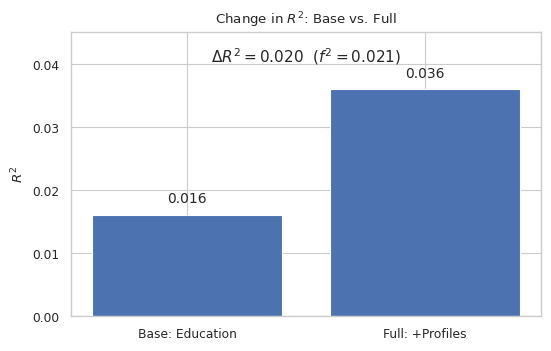

Saved: /content/outputs/files/fig_r2change_model3.png | ΔR^2 = 0.020 | f^2 = 0.021


In [134]:
# === B) Fig: Change in R² (Full vs. Base) + Cohen's f² ===

assert 'm1' in globals(), "m1 (Education-only) missing."
assert 'm3' in globals(), "m3 (Education + Profiles) missing."

r2_base = float(m1.rsquared)
r2_full = float(m3.rsquared)
delta_r2 = r2_full - r2_base
f2 = delta_r2 / (1 - r2_full)   # Cohen's f^2 relative to full model

labels = ['Base: Education', 'Full: +Profiles']
values = [r2_base, r2_full]

plt.figure(figsize=(5.6, 3.6))
bars = plt.bar(np.arange(2), values)
top = max(values) * 1.25
plt.ylim(0, top)

for i, v in enumerate(values):
    plt.text(i, v + top*0.03, f"{v:.3f}", ha='center', va='bottom', fontsize=10)

plt.text(0.5, top*0.95,
         rf"$\Delta R^2 = {delta_r2:.3f}$  ($f^2 = {f2:.3f}$)",
         ha='center', va='top', fontsize=11)

plt.xticks(np.arange(2), labels)
plt.ylabel(r"$R^2$")
plt.title("Change in $R^2$: Base vs. Full")
plt.tight_layout()

OUTDIR = OUTDIR if 'OUTDIR' in globals() else "./figures"
os.makedirs(OUTDIR, exist_ok=True)
out_path = os.path.join(OUTDIR, "fig_r2change_model3.png")
plt.savefig(out_path, dpi=300)
plt.show()

print("Saved:", out_path, "| ΔR^2 =", f"{delta_r2:.3f}", "| f^2 =", f"{f2:.3f}")


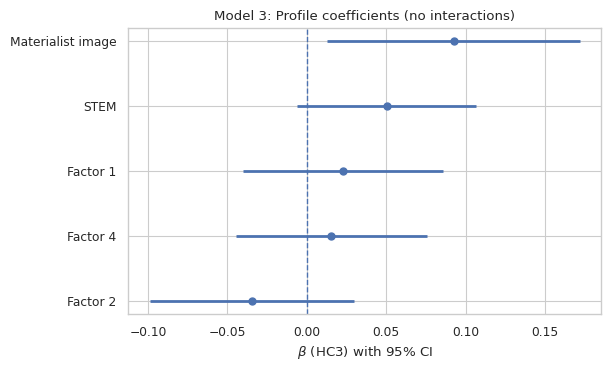

Saved: /content/outputs/files/fig_forest_m3_profiles.png
Plotted terms (order): ['Factor2_c', 'Factor4_c', 'Factor1_c', 'STEM_c', 'materialist_image_c']


In [135]:
# === C) Fig: Forest plot of Model 3 profile coefficients (HC3, 95% CI) ===

assert 'm3' in globals(), "m3 is missing (fit the full model first)."
assert 'PERS' in globals() and len(PERS) > 0, "PERS (profile terms) missing."

# Collect coefficients & CIs for profile terms
ci = m3.conf_int().rename(columns={0: "ci_lo", 1: "ci_hi"})
rows = []
for term in PERS:
    if term not in m3.params.index:
        print(f"[warn] term '{term}' not in model params; skipping")
        continue
    beta = float(m3.params[term])
    lo, hi = map(float, ci.loc[term])
    rows.append((term, beta, lo, hi))

dfp = (pd.DataFrame(rows, columns=["term","beta","ci_lo","ci_hi"])
         .sort_values("beta")
         .reset_index(drop=True))

# Optional pretty labels
label_map = {
    "materialist_image_c": "Materialist image",
    "STEM_c":              "STEM",
    "Factor1_c":           "Factor 1",
    "Factor2_c":           "Factor 2",
    "Factor4_c":           "Factor 4",
}
dfp["label"] = dfp["term"].map(lambda t: label_map.get(t, t))

# Plot
y = np.arange(len(dfp))
plt.figure(figsize=(6.2, 3.8))
plt.hlines(y, dfp["ci_lo"], dfp["ci_hi"], linewidth=2)   # 95% CI
plt.plot(dfp["beta"], y, "o", ms=5)                       # point estimate
plt.axvline(0, linestyle="--", linewidth=1)
plt.yticks(y, dfp["label"])
plt.xlabel(r"$\beta$ (HC3) with 95% CI")
plt.title("Model 3: Profile coefficients (no interactions)")
plt.tight_layout()

os.makedirs(OUTDIR, exist_ok=True)
forest_path = os.path.join(OUTDIR, "fig_forest_m3_profiles.png")
plt.savefig(forest_path, dpi=300)
plt.show()

print("Saved:", forest_path)
print("Plotted terms (order):", dfp["term"].tolist())


### Joint tests, diagnostics, robustness, and correlations

In [136]:
# A) Preconditions & helper
import re, numpy as np, pandas as pd
import statsmodels.formula.api as smf

assert 'm3' in globals(), "Run Model 3 first."
assert all(k in globals() for k in ['df','happiness','edu_term','pers_cols_df'])

def pick_col(col):
    for cand in (f"{col}_c", f"{col.lower()}_c", f"{col.upper()}_c", col):
        if cand in df.columns:
            return cand
    raise KeyError(f"Column '{col}' (or centered variant) not found in df")

PERS = [pick_col(c) for c in pers_cols_df]         # must match terms in m3
m = re.search(r"C\(([^)]+)\)", edu_term)           # extract inner name from C(...)
edu_name = m.group(1) if m else None


In [137]:
# B) Joint Wald/F-tests (HC3): Education overall + all profiles together
edu_param_idx = [j for j, nm in enumerate(m3.params.index) if nm.startswith(f"C({edu_name})[T.")]
R_edu = np.zeros((len(edu_param_idx), len(m3.params)))
for r, j in enumerate(edu_param_idx): R_edu[r, j] = 1.0
wald_edu = m3.wald_test(R_edu, use_f=True) if len(edu_param_idx) else None

prof_param_idx = [j for j, nm in enumerate(m3.params.index) if nm in PERS]
R_prof = np.zeros((len(prof_param_idx), len(m3.params)))
for r, j in enumerate(prof_param_idx): R_prof[r, j] = 1.0
wald_prof = m3.wald_test(R_prof, use_f=True)

print("=== Joint Wald/F (HC3) ===")
print("Education overall:\n", wald_edu if wald_edu is not None else "— no dummies —", "\n")
print("All profiles jointly = 0:\n", wald_prof)


=== Joint Wald/F (HC3) ===
Education overall:
 <F test: F=array([[4.31641239]]), p=0.004921221037450589, df_denom=996, df_num=3> 

All profiles jointly = 0:
 <F test: F=array([[3.45545298]]), p=0.004215258395837604, df_denom=996, df_num=5>


In [138]:
# C) Model fit comparison: Base (Education only) vs Full (Education + Profiles)
formula_base = f"{happiness} ~ {edu_term}"
m_base = smf.ols(formula_base, data=df, missing='drop').fit(cov_type="HC3")

print("=== R^2 comparison ===")
print(f"Base (Education):     R²={m_base.rsquared:.3f}, adj.R²={m_base.rsquared_adj:.3f}, n={int(m_base.nobs)}")
print(f"Full (+Profiles):     R²={m3.rsquared:.3f},  adj.R²={m3.rsquared_adj:.3f},  n={int(m3.nobs)}")
print(f"ΔR² = {m3.rsquared - m_base.rsquared:+.3f} | Δadj.R² = {m3.rsquared_adj - m_base.rsquared_adj:+.3f}")
print("Block significance is given by the joint Wald/F above (robust to heteroskedasticity).")


=== R^2 comparison ===
Base (Education):     R²=0.016, adj.R²=0.013, n=1005
Full (+Profiles):     R²=0.036,  adj.R²=0.028,  n=1005
ΔR² = +0.020 | Δadj.R² = +0.015
Block significance is given by the joint Wald/F above (robust to heteroskedasticity).


In [139]:
# D) Multicollinearity & pairwise correlations among profiles (using rows used by m3)

df_m3 = m3.model.data.frame.copy()
X = df_m3[PERS].copy()
X_std = (X - X.mean()) / X.std(ddof=0)            # numeric stabilizer for VIF
X_mat = np.column_stack([np.ones(len(X_std)), X_std.values])

vif_df = pd.DataFrame({
    "term": ["Intercept"] + list(X_std.columns),
    "VIF":  [variance_inflation_factor(X_mat, k) for k in range(X_mat.shape[1])]
})
vif_df = vif_df[vif_df["term"] != "Intercept"].sort_values("VIF", ascending=False).reset_index(drop=True)

print("=== VIF (profiles) ===")
display(vif_df)

corr = X.corr().abs()
tri = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
pairs = (tri.stack().reset_index()
         .rename(columns={"level_0":"var1", "level_1":"var2", 0:"|r|"})
         .sort_values("|r|", ascending=False))
print("Top |r| between profiles:")
display(pairs.head(10))


=== VIF (profiles) ===


,term,VIF
0,materialist_image_c,1.575709
1,Factor1_c,1.551632
2,Factor4_c,1.151192
3,STEM_c,1.100426
4,Factor2_c,1.079746


Top |r| between profiles:


,var1,var2,|r|
9,Factor1_c,materialist_image_c,0.551419
0,Factor2_c,STEM_c,0.219214
4,STEM_c,Factor4_c,0.210187
8,Factor4_c,materialist_image_c,0.203856
2,Factor2_c,Factor1_c,0.170743
3,Factor2_c,materialist_image_c,0.081792
7,Factor4_c,Factor1_c,0.076593
5,STEM_c,Factor1_c,0.072193
1,Factor2_c,Factor4_c,0.019363
6,STEM_c,materialist_image_c,0.002344


In [140]:
# E) Diagnostics: normality, heteroskedasticity, influential obs (Cook's D)

ad_stat, ad_p = normal_ad(m3.resid)
lm, lm_p, f_stat, f_p = het_breuschpagan(m3.resid, m3.model.exog)

infl = OLSInfluence(m3)
cd = infl.cooks_distance[0]
thr = 4/len(cd)
n_out = int((cd > thr).sum())

print(f"AD normality: stat={ad_stat:.3f}, p={ad_p:.3g}")
print(f"Breusch–Pagan: LM p={lm_p:.3g}, F p={f_p:.3g} (SE are HC3-robust)")
print(f"Cook's D: threshold≈{thr:.4f}, n above threshold = {n_out}")


AD normality: stat=22.212, p=0
Breusch–Pagan: LM p=0.0487, F p=0.0482 (SE are HC3-robust)
Cook's D: threshold≈0.0040, n above threshold = 57


In [141]:
# Sensitivity — drop high Cook's D, refit Model 3 (HC3), compare coefficients  ✅ FIXED

df_used = m3.model.data.frame.copy()

infl = OLSInfluence(m3)
cd = infl.cooks_distance[0]
thr = 4 / len(cd)

# Make mask boolean and aligned to df_used's index
mask_keep = pd.Series(cd <= thr, index=df_used.index, dtype=bool)

# Counts (avoid "~" on a non-bool Series)
n_keep = int(np.count_nonzero(mask_keep.values))
n_drop = int(mask_keep.size - n_keep)
print(f"Keeping {n_keep} / {mask_keep.size} rows (drop {n_drop})")

# Refit on kept rows
m3_drop = smf.ols(m3.model.formula, data=df_used.loc[mask_keep]).fit(cov_type="HC3")

# Compare coefficients for profiles
terms = [t for t in PERS if t in m3.params.index and t in m3_drop.params.index]
cmp = pd.DataFrame({
    "term": terms,
    "beta_orig": [m3.params[t] for t in terms],
    "p_orig":    [m3.pvalues[t] for t in terms],
    "beta_drop": [m3_drop.params[t] for t in terms],
    "p_drop":    [m3_drop.pvalues[t] for t in terms],
})
display(cmp)
print(f"Adj R²: original={m3.rsquared_adj:.3f} | drop={m3_drop.rsquared_adj:.3f}")


Keeping 949 / 1006 rows (drop 57)


,term,beta_orig,p_orig,beta_drop,p_drop
0,Factor2_c,-0.034642,0.290918,-0.055117,0.049124
1,STEM_c,0.050433,0.079617,0.051962,0.036089
2,Factor4_c,0.015547,0.613672,0.010549,0.685459
3,Factor1_c,0.022782,0.479977,0.036787,0.191772
4,materialist_image_c,0.092469,0.022545,0.111015,0.000702


Adj R²: original=0.028 | drop=0.055


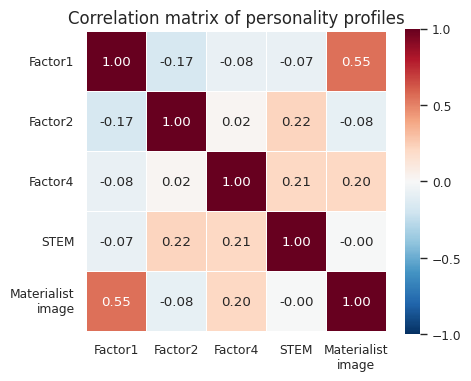

Saved: /content/outputs/files/fig_corr_profiles_polished.png | /content/outputs/files/fig_corr_profiles_polished.pdf


In [142]:
# G) Publication-style correlation heatmap for profiles (seaborn)

try:
    import seaborn as sns
except Exception as e:
    raise RuntimeError("This cell requires seaborn (pip install seaborn).") from e

assert 'OUTDIR' in globals(), "Define OUTDIR (output folder)."
FIGDIR = os.path.join(OUTDIR, "figures"); os.makedirs(FIGDIR, exist_ok=True)

# keep preferred order
CANDIDATES = ["Factor1","Factor2","Factor4","STEM","materialist_image"]
def _pick(c):
    for cand in (f"{c}_c", f"{c.lower()}_c", f"{c.upper()}_c", c):
        if cand in df.columns and pd.api.types.is_numeric_dtype(df[cand]): return cand
    return None
order = [x for x in (_pick(c) for c in CANDIDATES) if x is not None]
corr = df[order].corr(method="pearson")

# pretty labels
def lab(s):
    b = s.replace("_c","").replace("_"," ").strip()
    return "Materialist\nimage" if "materialist" in b.lower() else b[:1].upper()+b[1:]

labs = [lab(c) for c in order]

sns.set(context="paper", style="white")
fig_w = max(4.8, 1.0 + 0.7*len(order)); fig_h = fig_w-0.5
fig, ax = plt.subplots(figsize=(fig_w, fig_h))
hm = sns.heatmap(corr, vmin=-1, vmax=1, cmap="RdBu_r", square=True,
                 linewidths=0.6, linecolor="white", annot=True, fmt=".2f",
                 cbar_kws={"shrink":0.82, "ticks":[-1,-0.5,0,0.5,1]})
ax.set_xticklabels(labs, rotation=0); ax.set_yticklabels(labs, rotation=0)
ax.set_title("Correlation matrix of personality profiles", fontsize=12)
plt.tight_layout()
png = os.path.join(OUTDIR, "fig_corr_profiles_polished.png")
pdf = os.path.join(OUTDIR, "fig_corr_profiles_polished.pdf")
plt.savefig(png, dpi=300); plt.savefig(pdf); plt.show()
print("Saved:", png, "|", pdf)


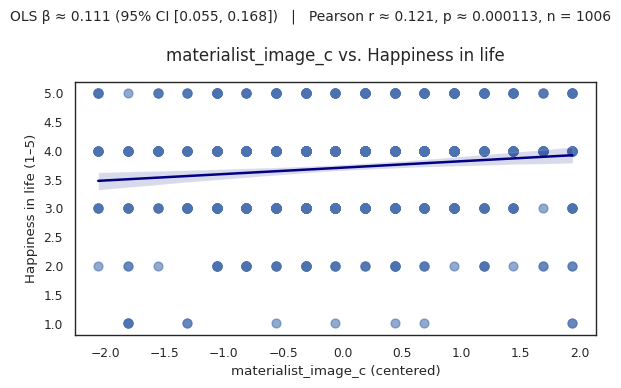

Saved: /content/outputs/files/fig_scatter_materialist_vs_happiness.png


In [143]:
OUTDIR = OUTDIR if 'OUTDIR' in globals() else "./figures"
os.makedirs(OUTDIR, exist_ok=True)

x_col = "materialist_image_c"
y_col = "Happiness_in_life"

# Clean data
xy = df[[x_col, y_col]].apply(pd.to_numeric, errors="coerce").dropna()
n = len(xy)

# OLS with pandas Series -> keeps names
X = sm.add_constant(xy[x_col])             # const + named predictor
ols = sm.OLS(xy[y_col], X).fit()
beta = float(ols.params[x_col])
ci_low, ci_high = map(float, ols.conf_int().loc[x_col])

# Pearson r
r, p = pearsonr(xy[x_col], xy[y_col])

# Plot
fig, ax = plt.subplots(figsize=(6, 4))
sns.regplot(x=x_col, y=y_col, data=xy, ax=ax,
            scatter_kws={'alpha':0.6, 's':40},
            line_kws={'color':'navy'})

ax.set_title(f"{x_col} vs. Happiness in life", fontsize=12, pad=15)
ax.set_xlabel(f"{x_col} (centered)")
ax.set_ylabel("Happiness in life (1–5)")

fig.text(0.5, 0.92,
         f"OLS β ≈ {beta:.3f} (95% CI [{ci_low:.3f}, {ci_high:.3f}])   |   "
         f"Pearson r ≈ {r:.3f}, p ≈ {p:.3g}, n = {n}",
         ha='center', va='bottom', fontsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.90])
out_path = os.path.join(OUTDIR, "fig_scatter_materialist_vs_happiness.png")
plt.savefig(out_path, dpi=300)
plt.show()
print("Saved:", out_path)


## Model 4 – Combined model with interaction

Goal: Add interaction terms between each personality profile and education.
Why: To see if the effect of personality on happiness depends on education level.

In [144]:
# === Model 4 — Education + all profiles + interactions (HC3) ===

# --- prerequisites from your prep pipeline ---
assert 'df' in globals() and 'happiness' in globals(), "Run data prep first."
assert 'edu_term' in globals() and edu_term is not None, "Set edu_term (e.g., 'C(Education_collapsed)')."
assert 'pers_cols_df' in globals() and pers_cols_df, "Give the list of personality profiles."

# Prefer centered columns if exist; otherwise use raw
def pick_col(col):
    for cand in (f"{col}_c", f"{col.lower()}_c", f"{col.upper()}_c", col):
        if cand in df.columns:
            return cand
    raise KeyError(f"Column '{col}' (or centered variant) not found in df")

PERS = [pick_col(c) for c in pers_cols_df]
profile_terms = " + ".join(PERS)
inter_terms   = " + ".join([f"{p}:{edu_term}" for p in PERS])

formula_m4 = f"{happiness} ~ {edu_term} + {profile_terms} + {inter_terms}"
m4 = smf.ols(formula_m4, data=df, missing="drop").fit(cov_type="HC3")

print("Model 4 – Combined with interactions (HC3)")
print("Formula:", formula_m4)
print(f"n = {int(m4.nobs)}, R² = {m4.rsquared:.3f}, adj.R² = {m4.rsquared_adj:.3f}")

# ---- tidy tables ----
ci = m4.conf_int().rename(columns={0:"ci_low",1:"ci_high"})
coef_tbl = (pd.DataFrame({
        "term": m4.params.index,
        "coef": m4.params.values,
        "se":   m4.bse.values,
        "t":    m4.tvalues.values,
        "p":    m4.pvalues.values,
    })
    .merge(ci, left_on="term", right_index=True)
)

# Education rows (vs. reference)
inner = re.search(r"C\(([^)]+)\)", edu_term).group(1) if edu_term.startswith("C(") else edu_term
edu_rows = coef_tbl[coef_tbl["term"].str.startswith(f"C({inner})")].reset_index(drop=True)

# Profile main-effects (no education, no intercept, no interaction)
prof_rows = coef_tbl[coef_tbl["term"].isin(PERS)].reset_index(drop=True)

# Interactions + BH FDR
int_rows = coef_tbl[coef_tbl["term"].str.contains(":")].copy().reset_index(drop=True)
if not int_rows.empty:
    _, q, _, _ = multipletests(int_rows["p"].values, method="fdr_bh")
    int_rows["q"] = q
    int_rows["sig_q<0.05"] = int_rows["q"] < 0.05

print("\nEducation contrasts (vs. baseline):")
display(edu_rows)

print("Profile main-effects (adjusted for Education & others):")
display(prof_rows.sort_values("p"))

print("Interactions (with BH q-values):")
display(int_rows.sort_values(["q","p"]) if "q" in int_rows else int_rows.sort_values("p"))

# The fitted model object is `m4`


Model 4 – Combined with interactions (HC3)
Formula: Happiness_in_life ~ C(Education_collapsed) + Factor2_c + STEM_c + Factor4_c + Factor1_c + materialist_image_c + Factor2_c:C(Education_collapsed) + STEM_c:C(Education_collapsed) + Factor4_c:C(Education_collapsed) + Factor1_c:C(Education_collapsed) + materialist_image_c:C(Education_collapsed)
n = 1005, R² = 0.061, adj.R² = 0.039

Education contrasts (vs. baseline):


,term,coef,se,t,p,ci_low,ci_high
0,C(Education_collapsed)[T.postgraduate],-0.096408,0.109440,-0.880927,0.378357,-0.310906,0.118089
1,C(Education_collapsed)[T.primary],-0.368419,0.131059,-2.811094,0.004937,-0.625290,-0.111548
2,C(Education_collapsed)[T.secondary school],-0.090595,0.066915,-1.353871,0.175777,-0.221746,0.040557


Profile main-effects (adjusted for Education & others):


,term,coef,se,t,p,ci_low,ci_high
1,STEM_c,0.166633,0.065891,2.528936,0.011441,0.037490,0.295777
4,materialist_image_c,0.178811,0.084635,2.112740,0.034623,0.012930,0.344692
2,Factor4_c,0.042485,0.067020,0.633913,0.526138,-0.088872,0.173842
0,Factor2_c,0.044748,0.081571,0.548576,0.583296,-0.115128,0.204624
3,Factor1_c,0.024048,0.081106,0.296499,0.766849,-0.134918,0.183014


Interactions (with BH q-values):


,term,coef,se,t,p,ci_low,ci_high,q,sig_q<0.05
5,STEM_c:C(Education_collapsed)[T.secondary school],-0.153269,0.074637,-2.053543,0.040020,-0.299554,-0.006984,0.600299,False
2,Factor2_c:C(Education_collapsed)[T.secondary s...,-0.144108,0.090658,-1.589571,0.111931,-0.321795,0.033579,0.825968,False
3,STEM_c:C(Education_collapsed)[T.postgraduate],-0.161228,0.126142,-1.278145,0.201198,-0.408462,0.086006,0.825968,False
7,Factor4_c:C(Education_collapsed)[T.primary],-0.184448,0.159265,-1.158125,0.246813,-0.496601,0.127705,0.825968,False
12,materialist_image_c:C(Education_collapsed)[T.p...,-0.202973,0.188235,-1.078295,0.280902,-0.571908,0.165961,0.825968,False
14,materialist_image_c:C(Education_collapsed)[T.s...,-0.095759,0.098383,-0.973334,0.330387,-0.288587,0.097068,0.825968,False
13,materialist_image_c:C(Education_collapsed)[T.p...,-0.154848,0.189098,-0.818878,0.412856,-0.525474,0.215778,0.878984,False
6,Factor4_c:C(Education_collapsed)[T.postgraduate],0.070366,0.126760,0.555110,0.578820,-0.178079,0.318810,0.878984,False
0,Factor2_c:C(Education_collapsed)[T.postgraduate],0.079675,0.144867,0.549990,0.582326,-0.204259,0.363609,0.878984,False
10,Factor1_c:C(Education_collapsed)[T.primary],0.070281,0.159935,0.439438,0.660344,-0.243185,0.383748,0.878984,False


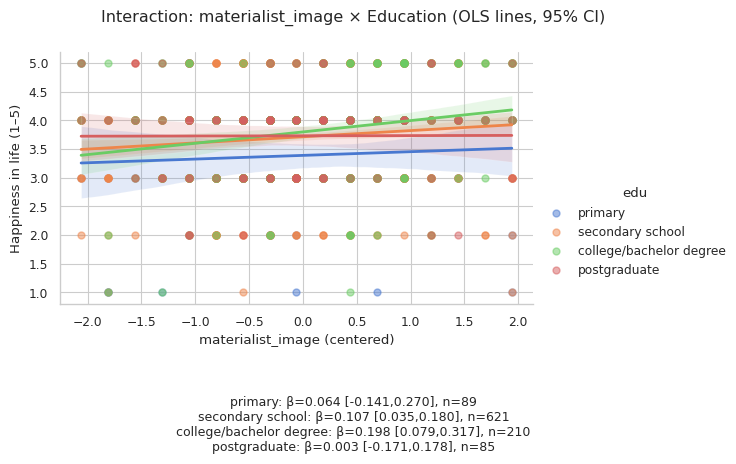

Saved: /content/outputs/files/interaction_plot_materialist_x_education.png


In [145]:
# Interaction plot: materialist_image × Education (grouped OLS lines + 95% CIs)

# Output folder
OUTDIR = OUTDIR if 'OUTDIR' in globals() else "./figures"
os.makedirs(OUTDIR, exist_ok=True)

# Columns
x_col, y_col, edu_col = "materialist_image_c", "Happiness_in_life", "Education_collapsed"

# --- clean & order ---
tmp = (
    df[[x_col, y_col, edu_col]]
      .rename(columns={x_col: "x", y_col: "y", edu_col: "edu"})
      .apply(pd.to_numeric, errors="ignore")
      .dropna(subset=["x", "y", "edu"])
)

order = ["primary", "secondary school", "college/bachelor degree", "postgraduate"]
order = [lvl for lvl in order if lvl in tmp["edu"].unique()]
tmp["edu"] = pd.Categorical(tmp["edu"], categories=order, ordered=True)

# --- plot (OLS per group, 95% CI) ---
sns.set(context="paper", style="whitegrid")
g = sns.lmplot(
    data=tmp, x="x", y="y", hue="edu",
    height=4.2, aspect=1.35, ci=95, palette="muted",
    scatter_kws={"alpha": 0.5, "s": 25}, line_kws={"linewidth": 2}
)
g.set_axis_labels("materialist_image (centered)", "Happiness in life (1–5)")
g.fig.suptitle("Interaction: materialist_image × Education (OLS lines, 95% CI)")

# --- per-group slopes (β) with 95% CI ---
rows = []
for lvl, sub in tmp.groupby("edu"):
    X = sm.add_constant(sub["x"])
    fit = sm.OLS(sub["y"], X).fit()
    beta = float(fit.params["x"])
    lo, hi = map(float, fit.conf_int().loc["x"])
    rows.append((lvl, beta, lo, hi, len(sub)))

annot = "\n".join(
    f"{lvl}: β={b:.3f} [{lo:.3f},{hi:.3f}], n={n}"
    for (lvl, b, lo, hi, n) in rows
)

# Make room at the bottom and place the annotation BELOW the plot
g.fig.subplots_adjust(top=0.88, bottom=0.28)   # extra bottom margin for text
g.fig.text(0.5, 0.06, annot, ha="center", va="top", fontsize=9)  # below axes

# --- save & show ---
out_path = os.path.join(OUTDIR, "interaction_plot_materialist_x_education.png")
g.savefig(out_path, dpi=300)
plt.show()
print("Saved:", out_path)


##Likelihood Ratio Test (GLRT) — Model 3 vs Model 4

In [146]:
# Guards (assumes m3 & m4 are already fit)
assert 'df' in globals()
assert 'm3' in globals() and 'm4' in globals(), "Fit m3 & m4 first."
assert 'happiness' in globals()
assert 'edu_term' in globals() and edu_term is not None
assert ('pers_cols_df' in globals()) or ('personality_cols' in globals())

# Use the EXACT rows used by m4
df_glrt = m4.model.data.frame.copy()
exog_names = pd.Index(m4.model.exog_names)
pers_list = pers_cols_df if 'pers_cols_df' in globals() else personality_cols


Build RHS (main effects like m4)

In [147]:
# === Build RHS main effects exactly as in m4 ===
PERS_USED = []
for c in pers_list:
    c_c = f"{c}_c"
    if c_c in exog_names:
        PERS_USED.append(c_c)
    elif c in exog_names:
        PERS_USED.append(c)

base_rhs = edu_term + ((" + " + " + ".join(PERS_USED)) if PERS_USED else "")

print("Base RHS (no interactions):")
print(base_rhs)


Base RHS (no interactions):
C(Education_collapsed) + Factor2_c + STEM_c + Factor4_c + Factor1_c + materialist_image_c


Find BH-significant interactions from m4

In [148]:
# === Interactions from m4 + BH selection (q=0.05) ===
int_rows = [t for t in m4.params.index if ":" in t]

inter_tbl = (
    pd.DataFrame({
        "term": int_rows,
        "coef": m4.params[int_rows],
        "se_HC3": m4.bse[int_rows],
        "p_value": m4.pvalues[int_rows],
    })
    .assign(
        ci_low=lambda d: m4.conf_int().loc[int_rows, 0].values,
        ci_high=lambda d: m4.conf_int().loc[int_rows, 1].values,
    )
    .sort_values("p_value")
    .reset_index(drop=True)
)

if len(inter_tbl) > 0:
    rejBH, p_adjBH, _, _ = multipletests(inter_tbl["p_value"].values, method="fdr_bh")
    inter_tbl["p_adj_bh"] = p_adjBH
    inter_tbl["sig_BH_0.05"] = rejBH
else:
    inter_tbl["p_adj_bh"] = []
    inter_tbl["sig_BH_0.05"] = []

keep_inters = inter_tbl.loc[inter_tbl.get("sig_BH_0.05", []), "term"].tolist()

print(f"BH-significant interactions (q=0.05): {len(keep_inters)}")
try:
    display(inter_tbl.loc[inter_tbl.get("sig_BH_0.05", []), ["term","coef","p_value","p_adj_bh"]].head(30))
except NameError:
    if len(keep_inters):
        print(inter_tbl.loc[inter_tbl["sig_BH_0.05"], ["term","coef","p_value","p_adj_bh"]].head(30).to_string(index=False))
    else:
        print("None passed BH.")


BH-significant interactions (q=0.05): 0


,term,coef,p_value,p_adj_bh


Fit reduced model (same rows as m4) & GLRT comparisons

In [149]:
# === Fit reduced model on the same rows as m4 ===
rhs_reduced = base_rhs if len(keep_inters) == 0 else (base_rhs + " + " + " + ".join(keep_inters))
formula_m4_reduced = f"{happiness} ~ {rhs_reduced}"
print("\nReduced formula:\n", formula_m4_reduced)

# Non-robust OLS (GLRT uses likelihoods; robust SEs don't change LL)
m4_reduced = smf.ols(formula_m4_reduced, data=df_glrt, missing="drop").fit()
m3_glrt    = smf.ols(m3.model.formula,     data=df_glrt, missing="drop").fit()

print(f"\nReduced model: N={int(m4_reduced.nobs)}, R²={m4_reduced.rsquared:.3f}, "
      f"Adj R²={m4_reduced.rsquared_adj:.3f}, AIC={m4_reduced.aic:.1f}, BIC={m4_reduced.bic:.1f}")

# --- GLRT helper ---
def glrt(m_small, m_big):
    ll0, ll1 = m_small.llf, m_big.llf
    df0 = int(m_small.df_model + 1)  # +1 for Intercept
    df1 = int(m_big.df_model + 1)
    df_diff = df1 - df0
    LR = 2.0 * (ll1 - ll0)
    p = stats.chi2.sf(LR, df_diff) if df_diff > 0 else np.nan
    return {"LR": LR, "df_diff": df_diff, "p_value": p}

# --- GLRTs on the same rows ---
tests = {
    "m3  vs m4_full":    glrt(m3_glrt, m4),
    "m3  vs m4_reduced": glrt(m3_glrt, m4_reduced),
    "m4_reduced vs m4":  glrt(m4_reduced, m4),
}
print("\n=== GLRT (chi-square) — same rows ===")
for name, res in tests.items():
    print(f"{name}: LR={res['LR']:.3f}, df={res['df_diff']}, p={res['p_value']:.4f}")

# --- Compact comparison table (same rows) ---
def model_row(name, m):
    return {"Model": name, "k (incl. Intercept)": int(m.df_model + 1),
            "N": int(m.nobs), "R2": m.rsquared, "R2_adj": m.rsquared_adj,
            "AIC": m.aic, "BIC": m.bic, "LL": m.llf}

cmp_models = pd.DataFrame([
    model_row("m3 (no inter)", m3_glrt),
    model_row("m4 (full inter)", m4),
    model_row("m4_reduced", m4_reduced),
]).sort_values("AIC").reset_index(drop=True)

print("\nModel comparison (sorted by AIC) — same rows:")
try:
    display(cmp_models)
except NameError:
    print(cmp_models.to_string(index=False))



Reduced formula:
 Happiness_in_life ~ C(Education_collapsed) + Factor2_c + STEM_c + Factor4_c + Factor1_c + materialist_image_c

Reduced model: N=1005, R²=0.036, Adj R²=0.028, AIC=2444.7, BIC=2488.9

=== GLRT (chi-square) — same rows ===
m3  vs m4_full: LR=26.637, df=15, p=0.0318
m3  vs m4_reduced: LR=0.000, df=0, p=nan
m4_reduced vs m4: LR=26.637, df=15, p=0.0318

Model comparison (sorted by AIC) — same rows:


,Model,k (incl. Intercept),N,R2,R2_adj,AIC,BIC,LL
0,m3 (no inter),9,1005,0.036096,0.028354,2444.674360,2488.889045,-1213.33718
1,m4_reduced,9,1005,0.036096,0.028354,2444.674360,2488.889045,-1213.33718
2,m4 (full inter),24,1005,0.061308,0.039300,2448.037601,2565.943428,-1200.01880


Common-sample GLRT + ΔR² & Partial R²

In [150]:
# === Common-sample GLRT + ΔR² / Partial R² (using reduced model rows) ===
df_glrt2 = m4_reduced.model.data.frame.copy()

m3_glrt2  = smf.ols(m3.model.formula,         data=df_glrt2, missing="drop").fit()
m4r_glrt2 = smf.ols(m4_reduced.model.formula, data=df_glrt2, missing="drop").fit()

def is_nested(m_small, m_big):
    return set(m_small.model.exog_names).issubset(set(m_big.model.exog_names))

assert int(m3_glrt2.nobs) == int(m4r_glrt2.nobs), "GLRT requires same N."
assert is_nested(m3_glrt2, m4r_glrt2), "Models not nested on this sample."

# GLRT
llf3, llf4r = m3_glrt2.llf, m4r_glrt2.llf
k3  = int(m3_glrt2.df_model) + 1
k4r = int(m4r_glrt2.df_model) + 1
df_diff_red = k4r - k3

LR_stat_red = 2.0 * (llf4r - llf3) if df_diff_red > 0 else 0.0
p_lr_red    = stats.chi2.sf(LR_stat_red, df_diff_red) if df_diff_red > 0 else np.nan

print("\nGLRT: Model 3 vs Model 4_reduced (same rows)")
print(f"LR = {LR_stat_red:.3f}, df = {df_diff_red}, p = {p_lr_red:.5f}")

# Optional F-test (order: full.compare_f_test(restricted))
try:
    F_val, pF, df_diff_F = m4r_glrt2.compare_f_test(m3_glrt2)
    print(f"Nested F-test: F = {F_val:.3f}, df = {df_diff_F}, p = {pF:.5f}")
except Exception as e:
    print("compare_f_test skipped:", e)

# ΔR² & Partial R²
R2_3, R2_4r = m3_glrt2.rsquared, m4r_glrt2.rsquared
deltaR2     = R2_4r - R2_3
partial_R2  = deltaR2 / (1.0 - R2_3) if (1.0 - R2_3) > 0 else np.nan

print(f"\nΔR² (block added) = {deltaR2:.4f}")
print(f"Partial R² (interactions block) = {partial_R2:.4f}")

# Compact same-sample table
cmp = pd.DataFrame([
    {"model": "Model 3 (no interaction)",
     "k": int(m3_glrt2.df_model) + 1, "nobs": int(m3_glrt2.nobs),
     "Adj_R2": m3_glrt2.rsquared_adj, "AIC": m3_glrt2.aic, "BIC": m3_glrt2.bic, "logLik": m3_glrt2.llf},
    {"model": "Model 4_reduced (kept sig. interactions)",
     "k": int(m4r_glrt2.df_model) + 1, "nobs": int(m4r_glrt2.nobs),
     "Adj_R2": m4r_glrt2.rsquared_adj, "AIC": m4r_glrt2.aic, "BIC": m4r_glrt2.bic, "logLik": m4r_glrt2.llf},
    {"model": "LR (M3 → M4_reduced)",
     "k": np.nan, "nobs": int(m4r_glrt2.nobs),
     "Adj_R2": np.nan, "AIC": np.nan, "BIC": np.nan, "logLik": LR_stat_red}
]).assign(
    dAIC=lambda d: d["AIC"] - d.loc[d["model"]=="Model 3 (no interaction)","AIC"].values[0],
    dBIC=lambda d: d["BIC"] - d.loc[d["model"]=="Model 3 (no interaction)","BIC"].values[0],
    dAdjR2=lambda d: d["Adj_R2"] - d.loc[d["model"]=="Model 3 (no interaction)","Adj_R2"].values[0]
)

print("\nModel comparison (same rows):")
try:
    display(cmp)
except NameError:
    print(cmp.to_string(index=False))



GLRT: Model 3 vs Model 4_reduced (same rows)
LR = 0.000, df = 0, p = nan
Nested F-test: F = nan, df = 0.0, p = nan

ΔR² (block added) = 0.0000
Partial R² (interactions block) = 0.0000

Model comparison (same rows):


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/linear_model.py:2284: RuntimeWarning: invalid value encountered in scalar divide
  f_value = (ssr_restr - ssr_full) / df_diff / ssr_full * df_full


,model,k,nobs,Adj_R2,AIC,BIC,logLik,dAIC,dBIC,dAdjR2
0,Model 3 (no interaction),9.0,1005,0.028354,2444.67436,2488.889045,-1213.33718,0.0,0.0,0.0
1,Model 4_reduced (kept sig. interactions),9.0,1005,0.028354,2444.67436,2488.889045,-1213.33718,0.0,0.0,0.0
2,LR (M3 → M4_reduced),NaN,1005,NaN,NaN,NaN,0.00000,NaN,NaN,NaN
